# ECG Analysis Notebook

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.stats import ttest_ind
import numpy as np
from sklearn.utils import resample
from statsmodels.stats.power import TTestIndPower, FTestPower


# Correcting Sharpness Deriv (normalizing)

In [2]:
# import pandas as pd
# import os

# # Function to normalize sharpness derivative by peak height
# def normalize_sharpness(df, peaks):
#     for peak in peaks:
#         sharpness_col = f'sharpness_deriv_{peak}'
#         height_col = f'{peak}_height'
#         norm_col = f'sharpness_deriv_{peak}_norm'
        
#         if sharpness_col in df.columns and height_col in df.columns:
#             df[norm_col] = df[sharpness_col] / df[height_col]
#         else:
#             print(f"Columns {sharpness_col} or {height_col} not found in DataFrame")
#     return df

# # Function to process and normalize ECG data for each subject
# def process_and_normalize_ecg_data(result_dir, peaks):
#     result_files = [f for f in os.listdir(result_dir) if f.endswith('_ecg_output.csv')]
    
#     for file in result_files:
#         file_path = os.path.join(result_dir, file)
        
#         # Load the ECG data
#         ecg_df = pd.read_csv(file_path)
        
#         # Normalize sharpness derivatives
#         ecg_df = normalize_sharpness(ecg_df, peaks)
        
#         # Save the updated DataFrame back to the file (or to a new file)
#         ecg_df.to_csv(file_path, index=False)
#         print(f"Processed and updated file: {file_path}")

# # Define the directory containing the results and peaks
# RESULT_DIR = '../docs/saved_files/timedomain_results/'
# PEAKS = ['p', 'q', 'r', 's', 't']

# # Process and normalize ECG data for all subjects
# process_and_normalize_ecg_data(RESULT_DIR, PEAKS)


# Global params

In [2]:


RESULT_DIR = '../docs/saved_files/timedomain_results/'
SUBJECT_INFO_FILE = '../docs/saved_files/subject-info.csv'
SUBJECT_DETAILS_FILE = '../docs/saved_files/spectral_results/subject_details.csv'
# SP_RESULTS_FILE = '../docs/saved_files/spectral_results/sp_results.csv'
PEAKS = ['p', 'q', 'r', 's', 't']
AGE_RANGES = {
    1: "18-19 years", 2: "20-24 years", 3: "25-29 years", 4: "30-34 years",
    5: "35-39 years", 6: "40-44 years", 7: "45-49 years", 8: "50-54 years",
    9: "55-59 years", 10: "60-64 years", 11: "65-69 years", 12: "70-74 years",
    13: "75-79 years", 14: "80-84 years", 15: "85-92 years"
}
SEX_VALUES = {0: "Male", 1: "Female"}
BMI_VALUES = {}


##########################################
#  Read and prepare subject information
########################################## ch

full_subject_info_df = pd.read_csv(SUBJECT_INFO_FILE)

# Ensure the subject numbers are extracted and matched correctly
result_files = [f for f in os.listdir(RESULT_DIR) if f.endswith('_ecg_output.csv')]
subject_nums = [f.split('_')[0].zfill(4) for f in result_files]

# Filter the DataFrame based on the extracted subject numbers
subject_info_df = full_subject_info_df[full_subject_info_df['ID'].astype(str).str.zfill(4).isin(subject_nums)].copy()

# Map Age_group to Age_range and Sex to Sex_class
subject_info_df.loc[:, 'Age_range'] = subject_info_df['Age_group'].map(AGE_RANGES).fillna("Unknown")
subject_info_df.loc[:, 'Sex_class'] = subject_info_df['Sex'].map(SEX_VALUES).fillna("Unknown")

# # Print and plot age and sex counts
# print("Age Range Counts for filtered subjects:")
# print(filtered_subject_info_df['Age_range'].value_counts().sort_index())
# print("\nSex Counts for filtered subjects:")
# print(filtered_subject_info_df['Sex_class'].value_counts().sort_index())

# plot_bar_chart(filtered_subject_info_df['Age_range'].value_counts().sort_index(),
#                'Histogram of Age Range Counts for Filtered Subjects', 'Age Range', 'Counts', 45)
# plot_bar_chart(filtered_subject_info_df['Sex_class'].value_counts().sort_index(),
#                'Histogram of Sex Counts for Filtered Subjects', 'Sex', 'Counts', colors=['blue', 'red'])

In [4]:
# from scipy.stats import f

# # Define parameters
# effect_size = 0.02  # Small effect size, indicating a small to medium expected effect size in the population.
# alpha = 0.05  # Significance level, typically set at 0.05 for a 5% chance of Type I error.
# power = 0.80  # Desired power of the test, typically set at 0.80 indicating an 80% chance of detecting a true effect.
# num_predictors = 3  # Number of predictors in the regression model: 

# # Calculate non-centrality parameter
# lambda_ = effect_size * num_predictors
# # Non-centrality parameter (λ) is calculated as the product of effect size and number of predictors.

# # Calculate critical F value
# df_denom = 1000  # Assuming a large denominator degrees of freedom for approximation.
# f_crit = f.ppf(1 - alpha, num_predictors, df_denom)
# # Critical F value (f_crit) for the given alpha level, number of predictors (degrees of freedom for the numerator), and a large denominator degrees of freedom.

# # Calculate required sample size
# n = (f_crit + f.isf(1 - power, num_predictors, df_denom)) / lambda_
# # Required sample size (n) is calculated using the critical F value, the inverse survival function of the F distribution for power, number of predictors, and non-centrality parameter.

# print(f"Approximate required sample size: {n:.2f}")
# # Output the approximate required sample size, formatted to two decimal places.

In [3]:
def plot_bar_chart(data, title, xlabel, ylabel, rotation=0, colors='blue'):
    plt.figure(figsize=(6, 4))
    data.plot(kind='bar', color=colors)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=rotation)
    plt.tight_layout()
    plt.show()

def plot_histogram(data, title, xlabel, ylabel, bins=20, color='skyblue'):
    plt.figure(figsize=(6, 4))
    plt.hist(data, bins=bins, color=color, edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

def plot_box_plot(data, title, xlabel, ylabel):
    plt.figure(figsize=(8, 6))
    plt.boxplot(data, patch_artist=True, showfliers=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()


## Computing average gaussian values: C, H, W

Filter the DataFrame:

age_filtered_subjects_over_60 contains only subjects with Age_group > 10.
Resample:

resample is used to create bootstrapped_subjects_over_60, which will have 200 samples.
replace=True allows for resampling with replacement, meaning each subject can appear multiple times.
n_samples=200 specifies the number of resampled subjects.
random_state=42 ensures reproducibility.


In [6]:
#Pull our subjects young and old
# Filter participants with age < 30
young_sub = subject_info_df[subject_info_df['Age_group'] < 3]
# Ensure only 200 participants are used
young_sub = young_sub.head(100)
print(f"Number of young sub: {len(young_sub)}")

# Filter participants with age > 60
old_sub = subject_info_df[subject_info_df['Age_group'] > 7]
print(f"Number of old sub: {len(old_sub)}")

Number of young sub: 100
Number of old sub: 48


In [7]:
def collect_peak_data(sub_files):
    # Initialize a dictionary to store peak data
    peak_data = {peak: {'center': [], 'height': [], 'width': []} for peak in PEAKS}
    excluded_cycles_count = 0
    kept_cycles_count = 0

    # Ensure 'ID' column is properly formatted as strings with leading zeros
    sub_files = sub_files.copy()
    sub_files.loc[:, 'ID'] = sub_files['ID'].astype(str).str.zfill(4)

    # Loop through each file in the result_files list
    for file_name in result_files:
        subject_num = file_name.split('_')[0].zfill(4)
        
        # Check if the subject number exists in the sub_files DataFrame
        if subject_num in sub_files['ID'].values:
            file_path = os.path.join(RESULT_DIR, file_name)
            try:
                # Read the ECG data from the CSV file
                ecg_data = pd.read_csv(file_path)
                
                # Filter rows where r_squared is greater than 0.9
                valid_data = ecg_data[ecg_data['r_squared'] > 0.9]
                excluded_cycles_count += len(ecg_data) - len(valid_data)
                kept_cycles_count += len(valid_data)
                
                # Loop through each peak and collect mean center, height, and width values for valid rows
                for peak in PEAKS:
                    if not valid_data.empty:
                        peak_data[peak]['center'].append(valid_data[f'{peak}_center'].mean())
                        peak_data[peak]['height'].append(valid_data[f'{peak}_height'].mean())
                        peak_data[peak]['width'].append(valid_data[f'{peak}_width'].mean())
            except Exception as e:
                # Print an error message if there is an issue reading the file
                print(f"Error processing file {file_path}: {e}")
    
    # Print the number of excluded cycles and kept cycles
    print(f"Total number of cycles excluded due to r_squared <= 0.9: {excluded_cycles_count}")
    print(f"Total number of cycles kept: {kept_cycles_count}")

    # Return the collected peak data
    return peak_data


In [8]:
# Collect data
young_sub_peaks = collect_peak_data(young_sub)
old_sub_peaks = collect_peak_data(old_sub)


Total number of cycles excluded due to r_squared <= 0.9: 13764
Total number of cycles kept: 95344
Total number of cycles excluded due to r_squared <= 0.9: 3986
Total number of cycles kept: 48301


In [9]:
def calculate_average_peaks(sub_peak_data, age_group, output_filename):
    # Initialize a dictionary to hold the sum of values and count of cycles for each peak
    sum_peaks = {peak: {'center': 0, 'height': 0, 'width': 0, 'count': 0} for peak in PEAKS}

    # Process each peak and accumulate the values
    for peak in PEAKS:
        sum_peaks[peak]['center'] = sum(sub_peak_data[peak]['center'])
        sum_peaks[peak]['height'] = sum(sub_peak_data[peak]['height'])
        sum_peaks[peak]['width'] = sum(sub_peak_data[peak]['width'])
        sum_peaks[peak]['count'] = len(sub_peak_data[peak]['center'])  # Assuming center, height, and width have the same number of entries

    total_peaks_processed = sum(sum_peaks[peak]['count'] for peak in PEAKS)
    print(f"Total valid peaks processed for {age_group}: {total_peaks_processed}")

    # Calculate the average values
    average_peaks = {peak: {
                        'center': sum_peaks[peak]['center'] / sum_peaks[peak]['count'] if sum_peaks[peak]['count'] > 0 else 0,
                        'height': sum_peaks[peak]['height'] / sum_peaks[peak]['count'] if sum_peaks[peak]['count'] > 0 else 0,
                        'width': sum_peaks[peak]['width'] / sum_peaks[peak]['count'] if sum_peaks[peak]['count'] > 0 else 0
                    } for peak in PEAKS}

    # # Display the average values
    # for peak, values in average_peaks.items():
    #     print(f"Peak {peak.upper()} ({age_group}):")
    #     print(f"  Center: {values['center']:.2f}")
    #     print(f"  Height: {values['height']:.2f}")
    #     print(f"  Width: {values['width']:.2f}")
    #     print()

    # Save these values to a file
    average_peaks_df = pd.DataFrame.from_dict(average_peaks, orient='index')
    average_peaks_df.to_csv(os.path.join(RESULT_DIR, output_filename))
    
    # Print Gaussian parameters as an array
    gaussian_params = np.array([values for peak in average_peaks.values() for values in peak.values()])
    print(f"Gaussian Parameters for {age_group}: {gaussian_params}")


# Calculate averages for participants with age < 30
calculate_average_peaks(young_sub_peaks, 'under 25', 'young_sub.csv')

# Calculate averages for participants with age > 60 using bootstrapped data
calculate_average_peaks(old_sub_peaks, 'over 50', 'old_sub.csv')


Total valid peaks processed for under 25: 495
Gaussian Parameters for under 25: [ 5.20183768e+05  2.35803531e+03  1.33419580e+01  5.20295538e+05
 -4.36195350e+03  1.69439814e+01  5.20329653e+05  3.63315551e+04
  9.77037122e+00  5.20362029e+05 -8.88128420e+03  1.32582704e+01
  5.20588380e+05  9.98785861e+03  3.45744290e+01]
Total valid peaks processed for over 50: 240
Gaussian Parameters for over 50: [ 5.21447541e+05  3.14568725e+03  1.68966171e+01  5.21568326e+05
 -4.54858266e+03  1.68776696e+01  5.21603634e+05  4.10254513e+04
  1.04713392e+01  5.21652373e+05 -7.61670219e+03  2.36167821e+01
  5.21876185e+05  9.93782246e+03  3.50477625e+01]


In [10]:
# Function to plot distributions
def plot_distributions(young_sub, old_sub):
    for peak in PEAKS:
        plt.figure(figsize=(10, 6))
        
        plt.subplot(2, 1, 1)
        plt.hist(young_sub[peak]['height'], bins=20, alpha=0.5, label=f'{peak} Height < 30', color='blue')
        plt.hist(old_sub[peak]['height'], bins=20, alpha=0.5, label=f'{peak} Height > 60', color='red')
        plt.xlabel('Height')
        plt.ylabel('Frequency')
        plt.title(f'{peak.upper()} Height Distribution')
        plt.legend()
        
        plt.subplot(2, 1, 2)
        plt.hist(young_sub[peak]['width'], bins=20, alpha=0.5, label=f'{peak} Width < 30', color='blue')
        plt.hist(old_sub[peak]['width'], bins=20, alpha=0.5, label=f'{peak} Width > 60', color='red')
        plt.xlabel('Width')
        plt.ylabel('Frequency')
        plt.title(f'{peak.upper()} Width Distribution')
        plt.legend()
        
        plt.tight_layout()
        plt.show()



## R squared

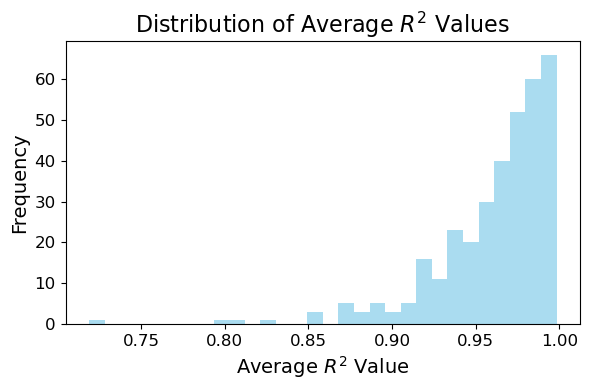

1042 has averaged R-squared less than 0.8
0804 has averaged R-squared less than 0.8


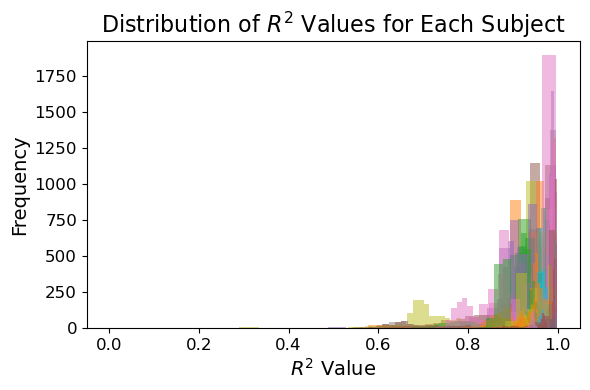

In [31]:
# Initialize r_squared_values Dictionary:
r_squared_values = {}

for file_name in result_files:
    df = pd.read_csv(os.path.join(RESULT_DIR, file_name))
    subject_num = file_name.split('_')[0].zfill(4)
    
    r_squared_non_zero = df['r_squared'].dropna()[df['r_squared'] > 0]
    r_squared_values[subject_num] = r_squared_non_zero.mean()

# Plot distribution of average R-squared values
average_r_squared_values = list(r_squared_values.values())

# Plotting function for histogram
def plot_histogram(data, title, xlabel, ylabel):
    plt.figure(figsize=(6, 4))
    plt.hist(data, bins=30, alpha=0.7, color='skyblue')
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

plot_histogram(average_r_squared_values, 'Distribution of Average $R^2$ Values',
               'Average $R^2$ Value', 'Frequency')

# Print subjects with average R-squared < 0.8
for subject_num, average_r_squared in r_squared_values.items():
    if average_r_squared < 0.8:
        print(f'{subject_num} has averaged R-squared less than 0.8')


# Collect R-squared values for each participant
        
# Initialize all_r_squared_values List:
all_r_squared_values = []

for file_name in result_files:
    subject_num = file_name.split('_')[0].zfill(4)
    df = pd.read_csv(os.path.join(RESULT_DIR, file_name))
    r_squared_non_zero = df['r_squared'].dropna()[df['r_squared'] > 0]
    r_squared_values[subject_num] = r_squared_non_zero.tolist()
    all_r_squared_values.extend(r_squared_non_zero)

# Plot histogram for the distribution of R-squared values for each subject
plt.figure(figsize=(6, 4))
for subject_num, values in r_squared_values.items():
    plt.hist(values, bins=30, alpha=0.5, label=f'Subject {subject_num}')

plt.title('Distribution of $R^2$ Values for Each Subject', fontsize=16)
plt.xlabel('$R^2$ Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.legend(loc='upper right', fontsize=10)  # Adjust font size of legend
plt.tight_layout()
plt.show()


Participant 1042 - Median R-squared: 0.7050, Mean R-squared: 0.7085
Participant 0804 - Median R-squared: 0.0000, Mean R-squared: 0.3604


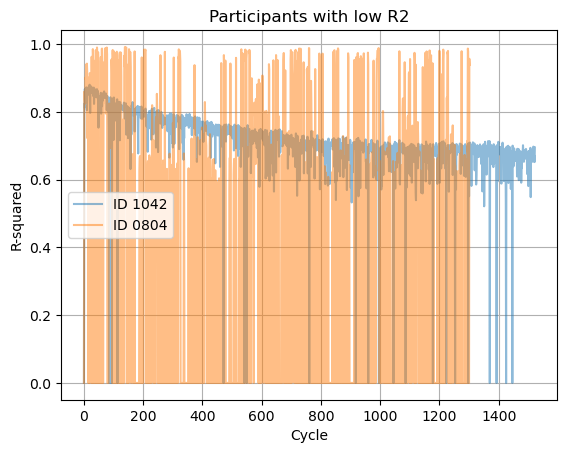

In [12]:

# Define the participant IDs to filter
#'0484', '0658', '0464', 
participant_ids = ['1042', '0804']
data_list = []

for file_name in result_files:
    subject_num = file_name.split('_')[0].zfill(4)
    if subject_num in participant_ids:
        file_path = os.path.join(RESULT_DIR, file_name)
        try:
            ecg_data = pd.read_csv(file_path)
            if 'r_squared' in ecg_data.columns:
                ecg_data['ID'] = subject_num
                ecg_data['cycle'] = ecg_data.index + 1  # Cycle number is the row index + 1
                data_list.append(ecg_data[['cycle', 'r_squared', 'ID']])
            else:
                print(f"'r_squared' column not found in {file_name}")
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

# Concatenate all participant data into a single DataFrame
r_squared_df = pd.concat(data_list)

# Calculate and print the median and mean R-squared values for each participant
for participant_id in participant_ids:
    participant_data = r_squared_df[r_squared_df['ID'] == participant_id]
    median_r_squared = participant_data['r_squared'].median()
    mean_r_squared = participant_data['r_squared'].mean()
    print(f'Participant {participant_id} - Median R-squared: {median_r_squared:.4f}, Mean R-squared: {mean_r_squared:.4f}')

    plt.plot(participant_data['cycle'], participant_data['r_squared'], label=f'ID {participant_id}',  alpha = 0.5)

    # # Plot the R-squared values over cycles if median and mean are above 0
    # if median_r_squared > 0 and mean_r_squared > 0:
    #     plt.plot(participant_data['cycle'], participant_data['r_squared'], label=f'ID {participant_id}',  alpha = 0.5)

# Customize and show the plot
plt.xlabel('Cycle')
plt.ylabel('R-squared')
plt.title('Participants with low R2')
plt.legend()
plt.grid(True)
# plt.tight_layout()
plt.show()

Total subjects in subject_info_df: 347


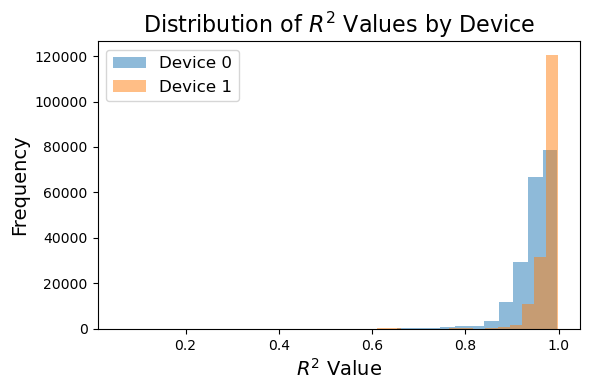

In [14]:


# Filter the DataFrame based on the extracted subject numbers
subject_info_df = full_subject_info_df[full_subject_info_df['ID'].astype(str).str.zfill(4).isin(subject_nums)].copy()

# Extract relevant columns and map Age_group to Age_range and Sex to Sex_class
subject_info_df['ID'] = subject_info_df['ID'].astype(str).str.zfill(4)
subject_info_df['Age_range'] = subject_info_df['Age_group'].map(AGE_RANGES).fillna("Unknown")
subject_info_df['Sex_class'] = subject_info_df['Sex'].map(SEX_VALUES).fillna("Unknown")

# Print subject counts
print(f"Total subjects in subject_info_df: {len(subject_info_df)}")

# Initialize dictionaries
r_squared_values = {}

# Extract and plot R-squared values
for file_name in result_files:
    df = pd.read_csv(os.path.join(RESULT_DIR, file_name))
    subject_num = file_name.split('_')[0].zfill(4)
    
    if 'r_squared' in df.columns:
        r_squared_non_zero = df['r_squared'].dropna()[df['r_squared'] > 0]
        if not r_squared_non_zero.empty:
            r_squared_values[subject_num] = r_squared_non_zero.tolist()
    else:
        print(f"'r_squared' column not found in {file_name}")

# Collect R-squared values for each device type
device_r_squared = {0: [], 1: []}

not_found_count = 0

for subject_num, values in r_squared_values.items():
    device_info = subject_info_df[subject_info_df['ID'] == subject_num]
    if not device_info.empty:
        device_type = device_info['Device'].values[0]
        device_r_squared[device_type].extend(values)
    else:
        not_found_count += 1
        print(f"Subject {subject_num} not found in subject info")


# Plot histogram for the distribution of R-squared values by device
plt.figure(figsize=(6, 4))

for device, values in device_r_squared.items():
    plt.hist(values, bins=30, alpha=0.5, label=f'Device {device}')


plt.title('Distribution of $R^2$ Values by Device', fontsize=16)
plt.xlabel('$R^2$ Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

Number of subjects not found in subject info: 0


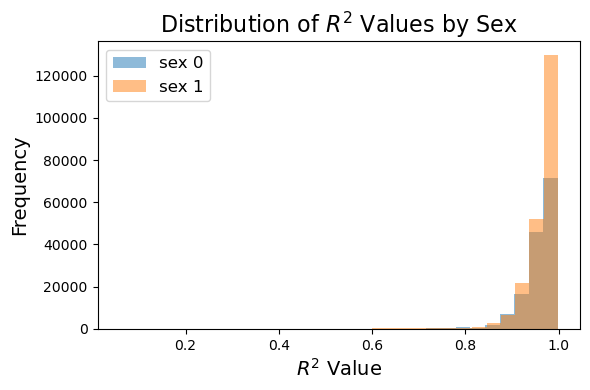

Average R-squared for sex 0: 0.9585
Average R-squared for sex 1: 0.9629


In [17]:
# Collect R-squared values for each device type
sex_r_squared = {0: [], 1: []}

not_found_count = 0

for subject_num, values in r_squared_values.items():
    sex_info = subject_info_df[subject_info_df['ID'] == subject_num]
    if not sex_info.empty:
        sex_type = sex_info['Sex'].values[0]
        sex_r_squared[sex_type].extend(values)
    else:
        not_found_count += 1
        print(f"Subject {subject_num} not found in subject info")

print(f"Number of subjects not found in subject info: {not_found_count}")

# Plot histogram for the distribution of R-squared values by device
plt.figure(figsize=(6, 4))

for sex, values in sex_r_squared.items():
    plt.hist(values, bins=30, alpha=0.5, label=f'sex {sex}')

plt.title('Distribution of $R^2$ Values by Sex', fontsize=16)
plt.xlabel('$R^2$ Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()

# Print average R-squared values for device groups
for sex, values in sex_r_squared.items():
    if values:
        average_r_squared = sum(values) / len(values)
        print(f'Average R-squared for sex {sex}: {average_r_squared:.4f}')
    else:
        print(f'No R-squared values found for sex {sex}')

In [17]:
### BMI 
# Ensure that the BMI column is not empty
valid_bmi_df = subject_info_df[subject_info_df['BMI'].notna()]
# Calculate the average BMI by sex
average_bmi_by_sex = valid_bmi_df.groupby('Sex')['BMI'].mean().reset_index()
# Calculate the average BMI by age group
average_bmi_by_age = valid_bmi_df.groupby('Age_group')['BMI'].mean().reset_index()
# Calculate the average BMI by sex and age group
average_bmi_by_sex_age = valid_bmi_df.groupby(['Sex', 'Age_group'])['BMI'].mean().reset_index()

print("Average BMI by Sex:")
print(average_bmi_by_sex)
print("\nAverage BMI by Age Group:")
print(average_bmi_by_age)
print("\nAverage BMI by Sex and Age Group:")
print(average_bmi_by_sex_age)


Average BMI by Sex:
   Sex        BMI
0  0.0  24.455882
1  1.0  23.909953

Average BMI by Age Group:
    Age_group        BMI
0         1.0  21.642857
1         2.0  22.777778
2         3.0  23.273973
3         4.0  24.054054
4         5.0  29.000000
5         6.0  24.769231
6         7.0  27.235294
7         8.0  29.300000
8         9.0  27.000000
9        10.0  27.181818
10       11.0  24.857143
11       12.0  24.500000
12       13.0  25.000000
13       14.0  28.000000

Average BMI by Sex and Age Group:
    Sex  Age_group        BMI
0   0.0        1.0  24.000000
1   0.0        2.0  22.457143
2   0.0        3.0  23.944444
3   0.0        4.0  24.368421
4   0.0        5.0  31.400000
5   0.0        6.0  23.125000
6   0.0        7.0  25.666667
7   0.0        8.0  27.200000
8   0.0       10.0  27.500000
9   0.0       11.0  26.000000
10  0.0       12.0  25.000000
11  0.0       14.0  24.000000
12  1.0        1.0  21.461538
13  1.0        2.0  22.901099
14  1.0        3.0  22.621622
15  1.0  

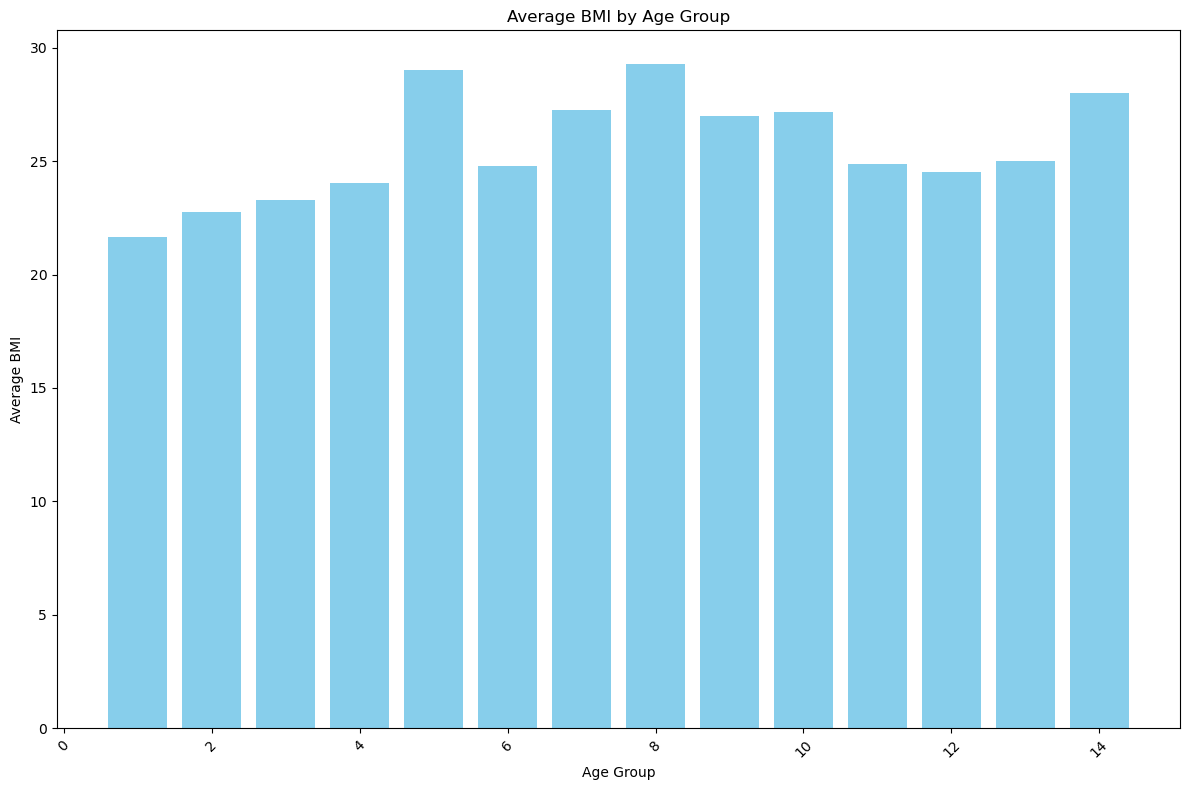

In [18]:
# Calculate the average BMI by age group
average_bmi_by_age = subject_info_df.groupby('Age_group')['BMI'].mean().reset_index()

# Plot the bar plot of average BMI by age group
plt.figure(figsize=(12, 8))
plt.bar(average_bmi_by_age['Age_group'], average_bmi_by_age['BMI'], color='skyblue')
plt.title('Average BMI by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average BMI')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

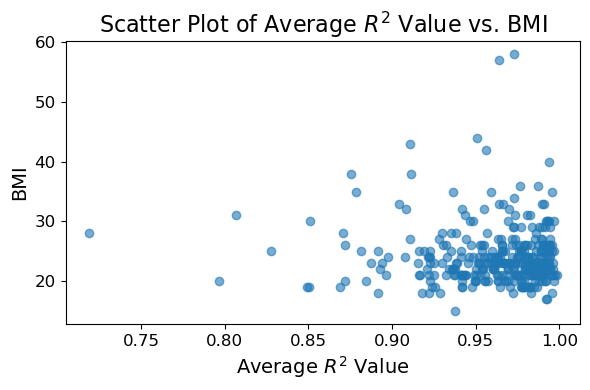

In [27]:
#R_SQUARED X BMI 

#Ensure the subject numbers are extracted and matched correctly
result_files = [f for f in os.listdir(RESULT_DIR) if f.endswith('_ecg_output.csv')]
subject_nums = [f.split('_')[0].zfill(4) for f in result_files]

# Filter the DataFrame based on the extracted subject numbers
subject_info_df = subject_info_df[subject_info_df['ID'].astype(str).str.zfill(4).isin(subject_nums)].copy()

# Convert the ID column to string and zero-pad
subject_info_df['ID'] = subject_info_df['ID'].astype(str).str.zfill(4)

# Initialize dictionary to hold the average R-squared values
avg_r_squared_values = {}

# Extract R-squared values and calculate the average for each participant
for file_name in result_files:
    df = pd.read_csv(os.path.join(RESULT_DIR, file_name))
    subject_num = file_name.split('_')[0].zfill(4)
    
    if 'r_squared' in df.columns:
        r_squared_non_zero = df['r_squared'].dropna()[df['r_squared'] > 0]
        if not r_squared_non_zero.empty:
            avg_r_squared_values[subject_num] = r_squared_non_zero.mean()
    else:
        print(f"'r_squared' column not found in {file_name}")

# Create a DataFrame from the avg_r_squared_values dictionary
r_squared_df = pd.DataFrame(list(avg_r_squared_values.items()), columns=['ID', 'avg_r_squared'])

# Convert the ID column to string and zero-pad
r_squared_df['ID'] = r_squared_df['ID'].astype(str).str.zfill(4)

# Merge the average R-squared values with the subject information DataFrame
merged_df = pd.merge(subject_info_df, r_squared_df, on='ID')



# Plot the scatter plot of average R-squared values against BMI
plt.figure(figsize=(6, 4))
plt.scatter(merged_df['avg_r_squared'], merged_df['BMI'], alpha=0.6)
plt.title('Scatter Plot of Average $R^2$ Value vs. BMI', fontsize=16)
plt.xlabel('Average $R^2$ Value', fontsize=14)
plt.ylabel('BMI', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.grid(True)
plt.tight_layout()
plt.show()

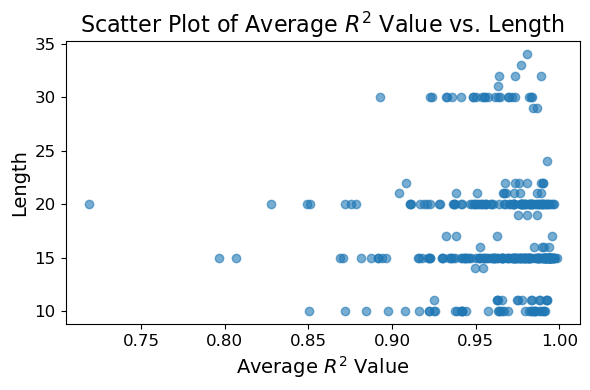

In [29]:
### Length
# Ensure that the Length column is not empty
valid_length_df = subject_info_df[subject_info_df['Length'].notna()]

# Calculate the average Length by sex
average_length_by_sex = valid_length_df.groupby('Sex')['Length'].mean().reset_index()

# Calculate the average Length by age group
average_length_by_age = valid_length_df.groupby('Age_group')['Length'].mean().reset_index()

# Calculate the average Length by sex and age group
average_length_by_sex_age = valid_length_df.groupby(['Sex', 'Age_group'])['Length'].mean().reset_index()

# print("Average Length by Sex:")
# print(average_length_by_sex)
# print("\nAverage Length by Age Group:")
# print(average_length_by_age)
# print("\nAverage Length by Sex and Age Group:")
# print(average_length_by_sex_age)

# Calculate the average Length by age group
average_length_by_age = subject_info_df.groupby('Age_group')['Length'].mean().reset_index()

# # Plot the bar plot of average Length by age group
# plt.figure(figsize=(12, 8))
# plt.bar(average_length_by_age['Age_group'], average_length_by_age['Length'], color='skyblue')
# plt.title('Average Length by Age Group')
# plt.xlabel('Age Group')
# plt.ylabel('Average Length')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# Initialize dictionary to hold the average R-squared values
avg_r_squared_values = {}

# Extract R-squared values and calculate the average for each participant
for file_name in result_files:
    df = pd.read_csv(os.path.join(RESULT_DIR, file_name))
    subject_num = file_name.split('_')[0].zfill(4)
    
    if 'r_squared' in df.columns:
        r_squared_non_zero = df['r_squared'].dropna()[df['r_squared'] > 0]
        if not r_squared_non_zero.empty:
            avg_r_squared_values[subject_num] = r_squared_non_zero.mean()
    else:
        print(f"'r_squared' column not found in {file_name}")

# Create a DataFrame from the avg_r_squared_values dictionary
r_squared_df = pd.DataFrame(list(avg_r_squared_values.items()), columns=['ID', 'avg_r_squared'])

# Convert the ID column to string and zero-pad
r_squared_df['ID'] = r_squared_df['ID'].astype(str).str.zfill(4)

# Merge the average R-squared values with the subject information DataFrame
merged_df = pd.merge(subject_info_df, r_squared_df, on='ID')

# Plot the scatter plot of average R-squared values against Length
plt.figure(figsize=(6, 4))
plt.scatter(merged_df['avg_r_squared'], merged_df['Length'], alpha=0.6)
plt.title('Scatter Plot of Average $R^2$ Value vs. Length', fontsize=16)
plt.xlabel('Average $R^2$ Value', fontsize=14)
plt.ylabel('Length', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.grid(True)
plt.tight_layout()
plt.show()

## Sharpness

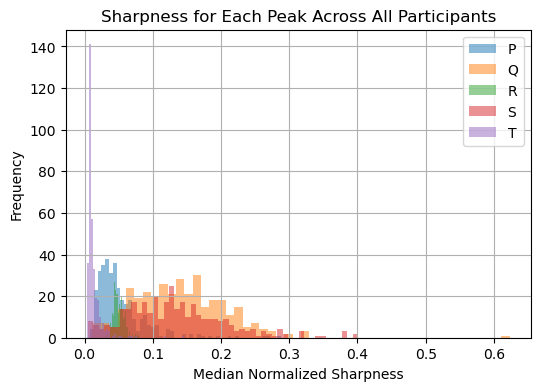

In [119]:
# Function to load and process each subject's ECG data
def process_subject_data(file_path):
    df = pd.read_csv(file_path)
    for peak in PEAKS:
        sharpness_col = f'sharpness_deriv_{peak}'
        height_col = f'{peak}_height'
        if sharpness_col in df.columns and height_col in df.columns:
            df[f'normalized_sharpness_{peak}'] = df[sharpness_col] / df[height_col]
            # Take the absolute value of the normalized sharpness
            df[f'normalized_sharpness_{peak}'] = df[f'normalized_sharpness_{peak}'].abs()
    return df

# Initialize an empty list to collect all median normalized sharpness values
all_medians = []

# Process each result file
for file in result_files:
    subject_id = file.split('_')[0].zfill(4)
    file_path = os.path.join(RESULT_DIR, file)
    subject_data = process_subject_data(file_path)
    subject_data['subject_id'] = subject_id
    # Calculate the median of the absolute normalized sharpness for each peak
    medians = subject_data.groupby('subject_id').median()
    all_medians.append(medians)

# Concatenate all median data into a single DataFrame
all_medians_df = pd.concat(all_medians)

# Plotting the distribution of medians for each peak
plt.figure(figsize=(6, 4))
for peak in PEAKS:
    col_name = f'normalized_sharpness_{peak}'
    if col_name in all_medians_df.columns:
        plt.hist(all_medians_df[col_name].dropna(), bins=50, alpha=0.5, label=peak.capitalize())
plt.title('Sharpness for Each Peak Across All Participants')
plt.xlabel('Median Normalized Sharpness')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

## Checkig Heights

In [120]:
# Function to load and combine data from multiple files
def load_and_combine_data(result_files, result_dir):
    combined_data = pd.DataFrame()
    for file_name in result_files:
        file_path = os.path.join(result_dir, file_name)
        data = pd.read_csv(file_path)
        combined_data = pd.concat([combined_data, data], ignore_index=True)
    return combined_data

# Load and combine data
combined_data = load_and_combine_data(result_files, RESULT_DIR)

# List of peak height columns to analyze
peak_height_columns = ['p_height', 'q_height', 'r_height', 's_height', 't_height']

# Function to calculate mean, median, and mode
def calculate_statistics(data, columns):
    stats = {}
    for column in columns:
        mean_val = data[column].mean()
        median_val = data[column].median()
        mode_val = data[column].mode().iloc[0] if not data[column].mode().empty else None
        stats[column] = {'mean': mean_val, 'median': median_val, 'mode': mode_val}
    return stats


# Calculate and display statistics for each peak height
peak_stats = calculate_statistics(combined_data, peak_height_columns)
peak_stats_df = pd.DataFrame(peak_stats).T
peak_stats_df

mean        median  mode
p_height   2507.680000   2294.495962   0.0
q_height  -4136.682937  -3840.520855   0.0
r_height  37980.205521  41269.590781   0.0
s_height  -6354.461232  -6480.833264   0.0
t_height   8252.385894   9493.108268   0.0

## Correlation Matrix

Pearson correlation coefficient between each pair of columns in the DataFrame.

The corr() method in pandas computes the Pearson correlation coefficient between pairs of columns in a DataFrame. This calculation is done across all rows in each pair of columns.

In [101]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# columns_of_interest = [
#  'p_height', 'p_width', 'q_height', 'q_width', 
#     'r_height', 'r_width', 's_height', 's_width',  't_height', 
#     't_width', 'r_squared', 'pr_interval', 'pr_segment', 'qrs_duration', 'st_segment', 'qt_interval', 
#     'p_duration', 'pp_interval', 'rr_interval',  'rise_time_p', 'decay_time_p', 
#     'rise_decay_symmetry_p', 'sharpness_deriv_p', 'sharpness_diff_p', 'rise_time_q', 
#     'decay_time_q', 'rise_decay_symmetry_q', 'sharpness_deriv_q',
#     'rise_time_r', 'decay_time_r', 'rise_decay_symmetry_r', 'sharpness_deriv_r', 
#      'rise_time_s', 'decay_time_s', 'rise_decay_symmetry_s', 'sharpness_deriv_s', 
#     'rise_time_t', 'decay_time_t', 'rise_decay_symmetry_t', 'sharpness_deriv_t',  
    
# ]

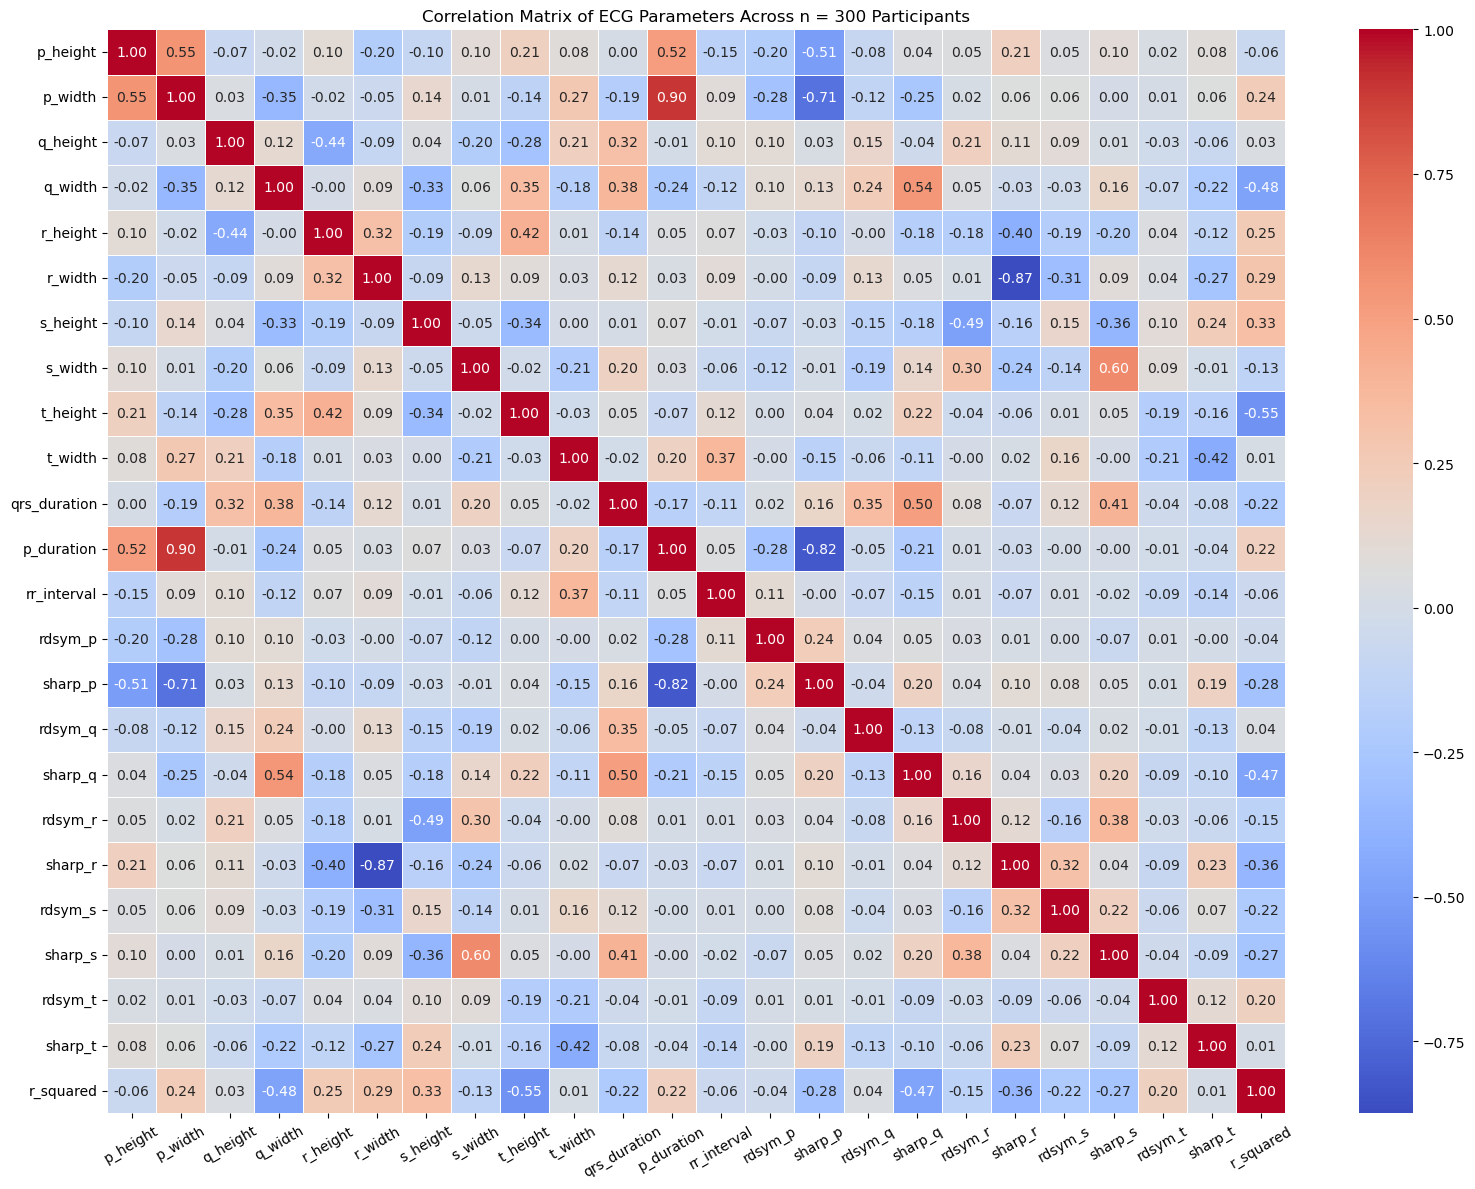

In [123]:
# Function to load and combine ECG data for all participants
def load_and_combine_ecg_data(result_dir):
    # List all ECG output files in the results directory
    result_files = [f for f in os.listdir(result_dir) if f.endswith('_ecg_output.csv')]
    
    # Initialize an empty list to store individual DataFrames
    data_frames = []
    
    # Load each file and append its DataFrame to the list
    for file in result_files:
        ecg_df = pd.read_csv(os.path.join(result_dir, file))
        data_frames.append(ecg_df)
    
    # Concatenate all DataFrames into a single DataFrame
    combined_df = pd.concat(data_frames, ignore_index=True)
    
    return combined_df

# Function to remove outliers using the IQR method
def remove_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Function to plot correlation matrix for combined data
def plot_combined_correlation_matrix(combined_df):
    # Filter the DataFrame to include only the columns of interest
    combined_filtered_df = combined_df[columns_of_interest]
    
    # Remove outliers from the filtered DataFrame
    combined_filtered_df = remove_outliers(combined_filtered_df, columns_of_interest)
    
    # Rename columns to shorter names
    combined_filtered_df.rename(columns=short_name_mapping, inplace=True)
    
    # Calculate the correlation matrix
    correlation_matrix = combined_filtered_df.corr()
    
    # Plot the correlation matrix using a heatmap
    plt.figure(figsize=(16, 12))
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix of ECG Parameters Across n = 300 Participants')
    plt.xticks(rotation=30)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# # Define the directory containing the results and the columns of interest
columns_of_interest = [
 'p_height', 'p_width', 'q_height', 'q_width', 
    'r_height', 'r_width', 's_height', 's_width',  't_height', 
    't_width',  'qrs_duration', 
    'p_duration',  'rr_interval', 
    'rise_decay_symmetry_p', 'sharpness_deriv_p_norm', 
     'rise_decay_symmetry_q', 'sharpness_deriv_q_norm',
     'rise_decay_symmetry_r', 'sharpness_deriv_r_norm', 
     'rise_decay_symmetry_s', 'sharpness_deriv_s_norm', 
     'rise_decay_symmetry_t', 'sharpness_deriv_t_norm',  
     'r_squared',
    
]

# Mapping of original column names to shorter names
short_name_mapping = {
    'rise_decay_symmetry_p': 'rdsym_p',
    'sharpness_deriv_p_norm': 'sharp_p',
    'rise_decay_symmetry_q': 'rdsym_q',
    'sharpness_deriv_q_norm': 'sharp_q',
    'rise_decay_symmetry_r': 'rdsym_r',
    'sharpness_deriv_r_norm': 'sharp_r',
    'rise_decay_symmetry_s': 'rdsym_s',
    'sharpness_deriv_s_norm': 'sharp_s',
    'rise_decay_symmetry_t': 'rdsym_t',
    'sharpness_deriv_t_norm': 'sharp_t'
}

# Load and combine ECG data for all participants
combined_ecg_data = load_and_combine_ecg_data(RESULT_DIR)

# Plot the correlation matrix for the combined data after removing outliers
plot_combined_correlation_matrix(combined_ecg_data)


# Extras

In [ ]:

##########################################
#  # #Onset and offset 
##########################################

# # Load and merge datasets for average exponent and offset values
# subject_details = pd.read_csv(SUBJECT_DETAILS_FILE)
# sp_results = pd.read_csv(SP_RESULTS_FILE)
# merged_data = pd.merge(subject_details, sp_results, on='Subject')
# merged_data = merged_data[merged_data['Age_range'] != 'Unknown']

# # Calculate and plot weighted averages
# mean_values = merged_data.groupby('Age_range')[['Offset_sp', 'Exponent_sp']].mean().reset_index()
# count_data = merged_data.groupby('Age_range')['Subject'].count().reset_index().rename(columns={'Subject': 'Count'})
# mean_values = mean_values.merge(count_data, on='Age_range')
# mean_values['Weighted_Offset_sp'] = mean_values['Offset_sp'] * mean_values['Count'] / mean_values['Count'].sum()
# mean_values['Weighted_Exponent_sp'] = mean_values['Exponent_sp'] * mean_values['Count'] / mean_values['Count'].sum()

# # Perform t-tests for significance testing
# age_20_to_30_ranges = ['20-24 years', '25-29 years']
# age_over_50_ranges = ['50-54 years', '55-59 years', '60-64 years', '65-69 years', '70-74 years', '75-79 years', '80-84 years', '85-92 years']
# age_20_to_30 = merged_data[merged_data['Age_range'].isin(age_20_to_30_ranges)]
# age_over_50 = merged_data[merged_data['Age_range'].isin(age_over_50_ranges)]

# t_stat_exp, p_value_exp = ttest_ind(age_20_to_30['Exponent_sp'], age_over_50['Exponent_sp'], equal_var=False)
# t_stat_offset, p_value_offset = ttest_ind(age_20_to_30['Offset_sp'], age_over_50['Offset_sp'], equal_var=False)

# # Output t-test results
# print(f'Exponent_sp t-test (20-30 vs. >50): t={t_stat_exp}, p={p_value_exp}')
# print(f'Offset_sp t-test (20-30 vs. >50): t={t_stat_offset}, p={p_value_offset}')


# MIMIC

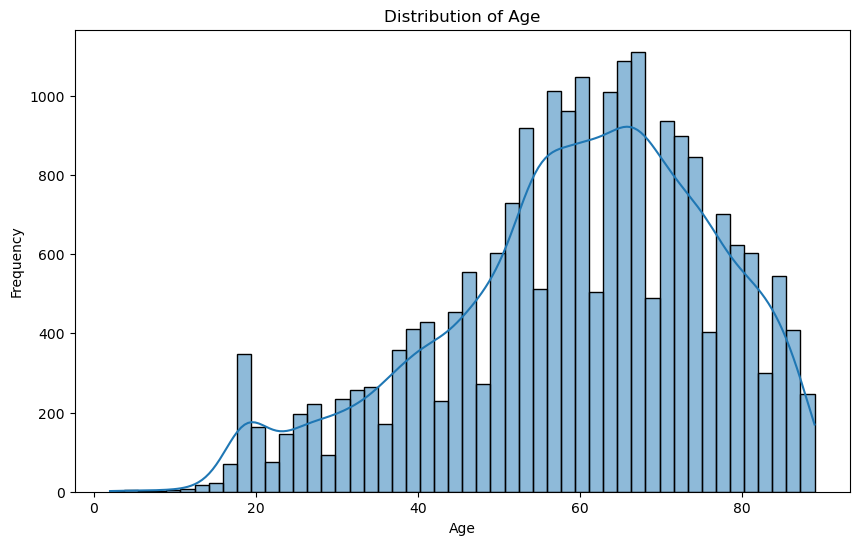

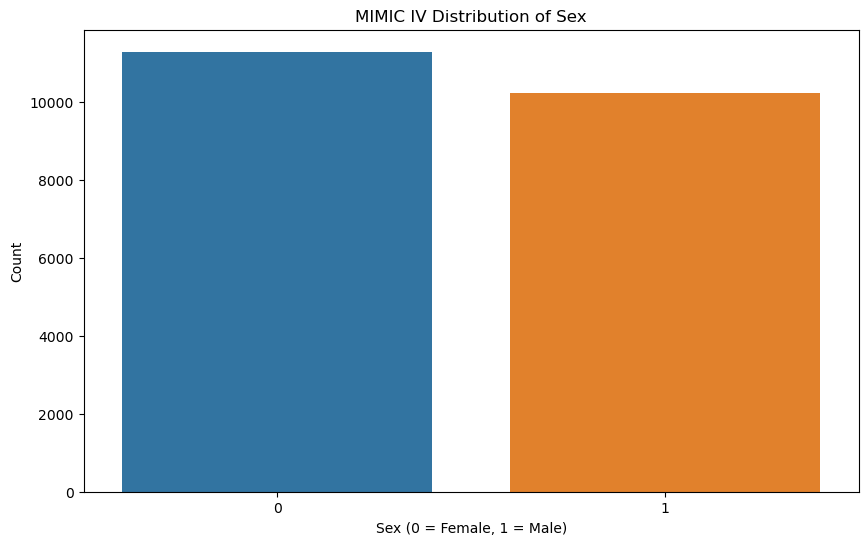

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = '../MIMIC_data/ptbxl_database.csv'
data = pd.read_csv(file_path)

# Filter out ages above 100
data_filtered = data[data['age'] <= 100]

# Plotting the distribution of age
plt.figure(figsize=(10, 6))
sns.histplot(data_filtered['age'].dropna(), bins=50, kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Plotting the distribution of sex
plt.figure(figsize=(10, 6))
sns.countplot(x='sex', data=data_filtered)
plt.title('MIMIC IV Distribution of Sex')
plt.xlabel('Sex (0 = Female, 1 = Male)')
plt.ylabel('Count')
plt.show()

In [54]:
# Filter out ages above 100
data_filtered = data[data['age'] <= 100].copy()

# Define age groups with bins of 5 years
bins = list(range(0, 105, 5))
labels = [f'{i}-{i+4}' for i in range(0, 100, 5)]
data_filtered['age_group'] = pd.cut(data_filtered['age'], bins=bins, labels=labels)

# Create a table with total number of participants per age group and sex
age_sex_distribution_5_years = data_filtered.pivot_table(index='age_group', columns='sex', aggfunc='size', fill_value=0)
age_sex_distribution_5_years.columns = ['Female', 'Male']

# Display the updated table
print(age_sex_distribution_5_years)


           Female  Male
age_group              
0-4             3     4
5-9             7     3
10-14          23    24
15-19         204   302
20-24         142   259
25-29         270   256
30-34         359   280
35-39         504   436
40-44         607   504
45-49         751   680
50-54        1245   912
55-59        1544   950
60-64        1604   988
65-69        1466  1139
70-74        1080  1132
75-79         731   997
80-84         518   927
85-89         228   427
90-94           0     0
95-99           0     0


In [60]:
# Calculate the number of individuals less than 20 and those over 60
less_than_20 = data_filtered[data_filtered['age'] < 30].shape[0]
over_60 = data_filtered[data_filtered['age'] > 60].shape[0]

# Print out the results
print(f"Number of individuals less than 20: {less_than_20}")
print(f"Number of individuals over 60: {over_60}")


# Calculate the total number of individuals in the dataset
total_individuals = data_filtered.shape[0]

# Print out the results
print(f"Total number of individuals in the dataset: {total_individuals}")

Number of individuals less than 20: 1379
Number of individuals over 60: 11237
Total number of individuals in the dataset: 21506


# Checking Bad Fits

In [4]:
import sys
print(sys.executable)
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import pandas as pd
import neurokit2 as nk
import numpy as np
import os

from src.gaussian_funcs import gaussian_function, compute_gauss_std, calc_r_squared
from src.utils import create_subject_file_mapping, extract_data, extract_metadata, compute_knee_frequency, compute_time_constant
from src.processing import simulate_ecg_signal, average_fft_of_epochs_loglog, extract_control_points, find_most_similar_signal, create_peak_params, get_peak_indices
from src.analysis import find_extremum, estimate_fwhm, find_peak_boundaries, generate_histograms, calculate_sharpness_deriv

from scipy.signal import detrend, butter, filtfilt, welch
from scipy.optimize import curve_fit


/Users/morganfitzgerald/miniconda3/envs/ecgenv/bin/python


In [5]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 5)

#FS = sampling rate; The sampling frequency of `ecg_signal` (in Hz, i.e., samples/second).
FS = 1000
fs = 1000
sampling_rate = 1000

CROP_MIN = 1000
CROP_MAX = 3000
WINDOW_LENGTH = 5000

FWHM_Q_IND = 5
FWHM_S_IND = 5
STD_R_HEIGHT = 10

PLOT = False

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import detrend

def epoch_signals(signals, ecg_clean, sampling_rate, SUB_NUM, PLOT=True, SAVE=False):
    # Ensure the lengths of P onsets, T offsets, and R peaks are identical, implying each cycle is complete.
    assert len(signals["ECG_P_Onsets"]) == len(signals["ECG_T_Offsets"])

    # Calculate the lengths of each cardiac cycle (from P onset to T offset) and compute the average cycle length.
    cycle_lens = np.zeros(len(signals["ECG_P_Onsets"]))
    for idx, (p_on, t_off) in enumerate(zip(signals["ECG_P_Onsets"], signals["ECG_T_Offsets"])):
        cycle_lens[idx] = t_off - p_on
    cycle_mean = np.nanmean(cycle_lens)

    # Filter out NaN values from P onsets to handle missing data points.
    nan_mask = np.isnan(signals["ECG_P_Onsets"])
    no_nan_p_on = np.asarray(signals["ECG_P_Onsets"])[~nan_mask]

    # Exclude the first and last cycles to avoid incomplete data at the beginning and end of the recording.
    no_nan_p_on = no_nan_p_on[1:-1]

    # Set the pre-cycle buffer and calculate the total epoch length including a post-cycle buffer.
    pre_p = 200  # Buffer before P Onset in milliseconds/sample points
    avg_cycle_len = cycle_mean + 200  # Buffer after end of cycle in milliseconds/sample points
    r_latencies = np.zeros(len(no_nan_p_on))
    ecg_clean_idx = np.arange(0, len(ecg_clean))
    epochs_df = pd.DataFrame(columns=["signal_x", "signal_y", "index", "cycle"])
    fig = plt.gcf()

    for idx, p_on in enumerate(no_nan_p_on):
        # Define each epoch using the calculated buffers.
        window_start = int(p_on) - int(pre_p)
        window_end = int(p_on) + int(avg_cycle_len)
        window = ecg_clean[window_start:window_end]

        # Apply detrending to remove linear trend from the epoch, enhancing signal analysis.
        window_detrended = detrend(window)

        # Generate time values for plotting, adjusted for the sampling frequency (sampling_rate).
        x_vals = np.linspace(-pre_p / sampling_rate, avg_cycle_len / sampling_rate, len(window_detrended))

        # Create a temporary DataFrame to store the current epoch's data.
        temp_df = pd.DataFrame({
            "signal_x": x_vals,
            "signal_y": window_detrended,
            "index": ecg_clean_idx[window_start:window_end],
            "cycle": np.repeat(idx + 1, len(x_vals))
        })

        # Append the epoch data to the main DataFrame containing all epochs, only if temp_df is not empty or all-NA.
        if not temp_df.empty and not temp_df.isna().all().all():
            epochs_df = pd.concat([epochs_df, temp_df])

        # Identify the R peak within the detrended epoch, storing its latency for further analysis.
        r_peak_ind = np.argmax(window_detrended)
        r_latencies[idx] = x_vals[r_peak_ind]

        # Plotting within loop only if PLOT is True
        if PLOT:
            # If it's the first epoch being plotted, create a new figure
            if idx == 0:
                plt.figure(figsize=(10, 6))
            plt.plot(x_vals, window_detrended)

    # Show and/or save the plot only if requested
    if PLOT:
        plt.title(f"Participant {SUB_NUM}: All Cycles Aligned to P Onset", size=10)
        plt.xlabel('Time (s)')
        plt.ylabel('ECG Signal (mV)')
        plt.show()

    if SAVE:
        # Ensure this block is executed only if plotting is done
        plt.savefig(f"../docs/figures/{SUB_NUM}_allcycles_alignedtoP.png")

    return epochs_df, r_latencies


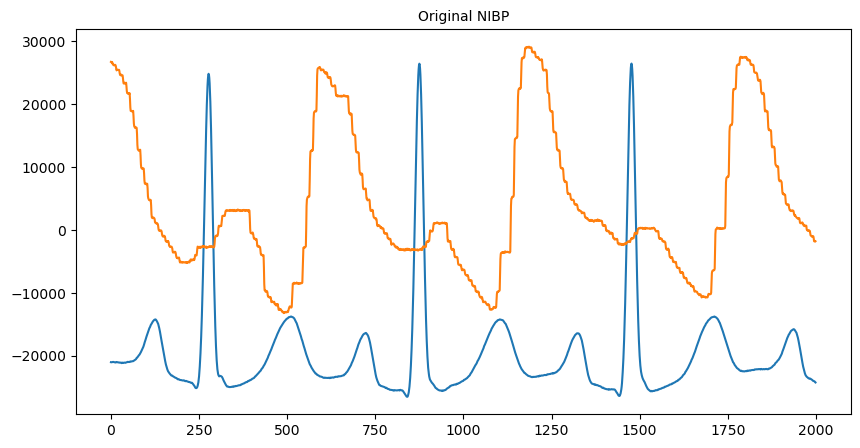

In [8]:
## Load signal 
# Manual input of subject number as a string to match dictionary keys
SUB_NUM = '804'  # Ensure this matches the format of your subject numbers in the dictionary

# Code to select the ECG signal
dir_path = '/Users/morganfitzgerald/Projects/ecg_param/data/raw'
files_dat_dict, files_hea_dict = create_subject_file_mapping(dir_path)

# Extract single subject
if SUB_NUM in files_dat_dict and SUB_NUM in files_hea_dict:
    sigs, metadata = extract_data(
        files_dat_dict[SUB_NUM],
        files_hea_dict[SUB_NUM],
        raw_dtype='int16'
    )
else:
    print(f"Subject number {SUB_NUM} not found.")
    
# Iterate through signals and plot only the original signals
for ind in range(metadata['n_sigs']):

    #plt.figure(figsize=(12, 2))

    # Original signal
    signal_name = metadata[f'sig{str(ind).zfill(2)}']['signal_name']
    original_signal = sigs[ind][CROP_MIN:CROP_MAX]
    
    plt.plot(original_signal)
    plt.title(f'Original {signal_name}', size=10)

# plt.show()

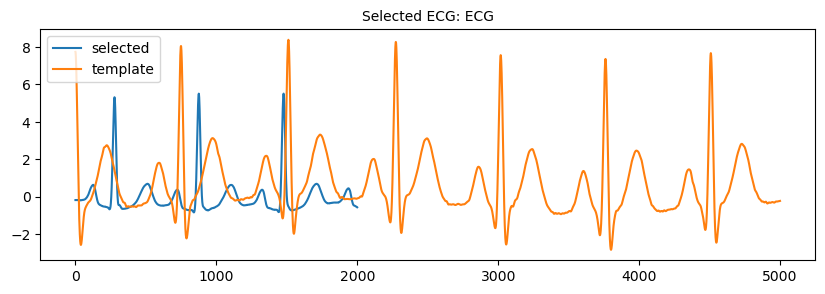

In [9]:
#SELECT THE SIGNAL
# Template ECG signal
template_ecg = simulate_ecg_signal(duration=5, sampling_rate=1000, heart_rate=80, amplitude_factor=7, normalize=False)

# List to store normalized signals
#Must normalize or the diff amplitudes mess up signal selection
normalized_signals = []

# Iterate through signals and normalize each
for ind in range(metadata['n_sigs']):
    signal_name = metadata[f'sig{str(ind).zfill(2)}']['signal_name']

    if signal_name == 'NIBP': 
        continue
    
    # Cut the signal shorter before normalization
    cropped_signal = sigs[ind][CROP_MIN:CROP_MAX]

    # Normalize the signal
    normalized_signal = (cropped_signal - np.mean(cropped_signal)) / np.std(cropped_signal)

    # Add normalized signal to the list

    normalized_signals.append(normalized_signal)

   #plt.plot(normalized_signal)

# Find the most similar signal to the template using cross-correlation
selected_signal, selected_signal_name, selected_signal_index = find_most_similar_signal(template_ecg, normalized_signals, metadata)

# Plot the most similar signal with the original signal name in the title
plt.figure(figsize=(10, 3))
plt.plot(selected_signal, label= 'selected')
plt.plot(template_ecg, label= 'template')
plt.legend()
plt.title(f'Selected ECG: {selected_signal_name}', size=10)
plt.show()

# Now 'ecg' contains the selected signal
ecg = sigs[selected_signal_index]


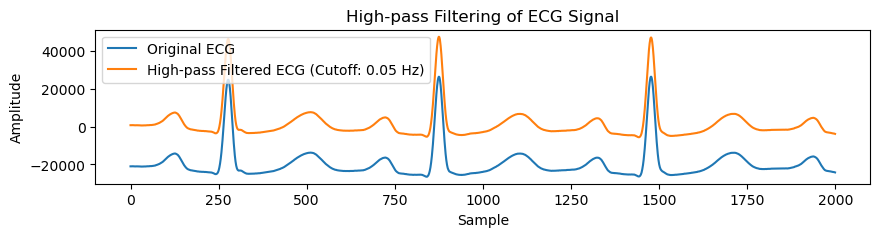

In [10]:

# Define the high-pass filter parameters
cutoff_frequency = 0.05  # Set your desired cutoff frequency in Hz
order = 4  # Set the filter order

# Design the high-pass filter
b, a = butter(order, cutoff_frequency, btype='high', analog=False, fs=metadata['fs'])

# Apply the high-pass filter to the ECG signal
ecg_hp = filtfilt(b, a, ecg)

# Plot the original and filtered signals
plt.figure(figsize=(10, 2))
plt.plot(ecg[CROP_MIN:CROP_MAX], label='Original ECG')
plt.plot(ecg_hp[CROP_MIN:CROP_MAX], label=f'High-pass Filtered ECG (Cutoff: {cutoff_frequency} Hz)')
plt.title('High-pass Filtering of ECG Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.show()



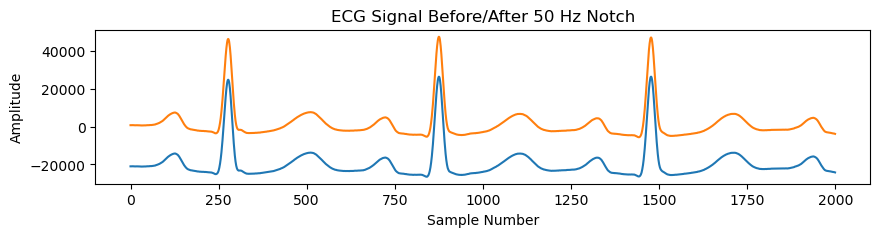

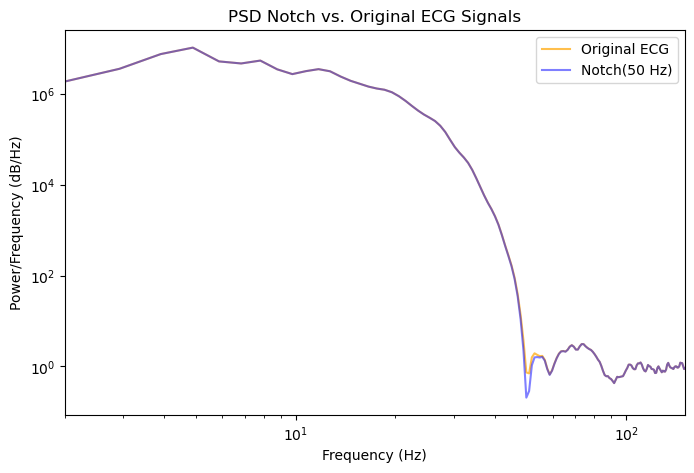

In [11]:
from scipy.signal import iirnotch, filtfilt
# import matplotlib.pyplot as plt
# import numpy as np

# Assuming 'ecg' is your ECG signal, 'fs' is the sampling rate
fs = metadata['fs']  # Sampling rate
f0 = 50  # Line noise frequency (50 Hz)
quality_factor = 30  # Quality factor, determines bandwidth around f0

# Design the bandstop (notch) filter
b, a = iirnotch(f0, quality_factor, fs)

# Apply the filter
ecg_notch = filtfilt(b, a, ecg_hp)

# Plotting
plt.figure(figsize=(10, 2))
plt.plot(ecg[CROP_MIN:CROP_MAX], label='Original ECG')
plt.plot(ecg_notch[CROP_MIN:CROP_MAX], label=f'High-pass Filtered ECG (Cutoff: {cutoff_frequency} Hz)')
plt.title('ECG Signal Before/After 50 Hz Notch')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
# plt.legend()
plt.show()


# Compute the PSD using Welch's method for the original ECG
f_original, Pxx_original = welch(ecg, fs, nperseg=1024)

# Compute the PSD using Welch's method for the ecg_notch filtered ECG
f_notch, Pxx_notch = welch(ecg_notch, fs, nperseg=1024)

# Plot the PSD for the original and high-pass filtered ECG signals
plt.figure(figsize=(8, 5))
# # Plot for original ECG signal
plt.loglog(f_original, Pxx_original, label='Original ECG', color = 'orange', alpha = 0.7)
# Plot for high-pass filtered ECG signal
plt.loglog(f_notch, Pxx_notch, label=f'Notch(50 Hz)', alpha = 0.5, color = 'blue')
plt.title('PSD Notch vs. Original ECG Signals')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.xlim([2, 150])  # Limit x-axis to 2-150 Hz
plt.legend()
plt.show()

<Figure size 1000x500 with 0 Axes>

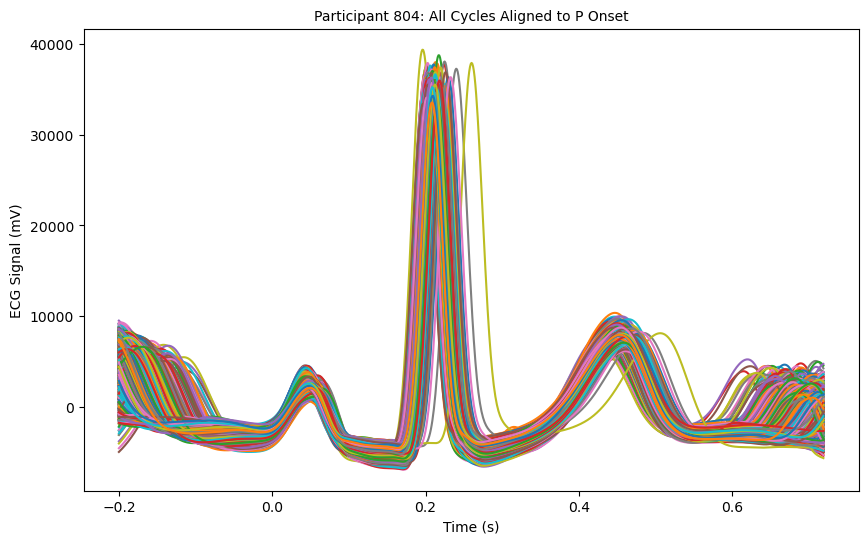

In [15]:
ecg_clean_nk = nk.ecg_clean(ecg, sampling_rate=1000)
p_peaks_nk, rpeaks_nk, waves_nk = extract_control_points(ecg_clean_nk, sampling_rate)
epochs_nk_df, _ = epoch_signals(p_peaks_nk, ecg_clean_nk, FS, SUB_NUM, PLOT = True, SAVE = False)

<Figure size 1000x500 with 0 Axes>

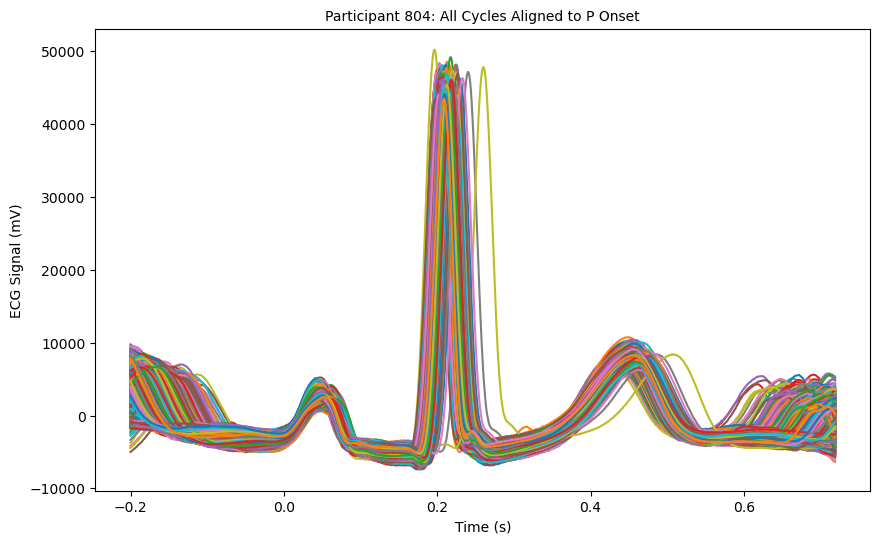

In [14]:
# Call the epoch functoin
epochs_df, result_r_latencies = epoch_signals(p_peaks_nk, ecg_notch,FS, SUB_NUM,  PLOT = True, SAVE = False)

In [17]:
# Number of unique cycles
num_cycles = len(epochs_df['cycle'].unique())

ecg_output_dict = {
    "cycle": np.arange(0, num_cycles).tolist(),
    "p_center": [np.nan] * num_cycles,
    "p_height": [np.nan] * num_cycles,
    "p_width": [np.nan] * num_cycles,
    "q_center": [np.nan] * num_cycles,
    "q_height": [np.nan] * num_cycles,
    "q_width": [np.nan] * num_cycles,
    "r_center": [np.nan] * num_cycles,
    "r_height": [np.nan] * num_cycles,
    "r_width": [np.nan] * num_cycles,
    "s_center": [np.nan] * num_cycles,
    "s_height": [np.nan] * num_cycles,
    "s_width": [np.nan] * num_cycles,
    "t_center": [np.nan] * num_cycles,
    "t_height": [np.nan] * num_cycles,
    "t_width": [np.nan] * num_cycles,
    "r_squared": [np.nan] * num_cycles,
    "pr_interval": [np.nan] * num_cycles,
    "pr_segment": [np.nan] * num_cycles,
    "qrs_duration": [np.nan] * num_cycles,
    "st_segment": [np.nan] * num_cycles,
    "qt_interval": [np.nan] * num_cycles,
    "p_duration": [np.nan] * num_cycles,
    "pp_interval": [np.nan] * num_cycles,
    "rr_interval": [np.nan] * num_cycles,
    "fwhm_p": [np.nan] * num_cycles,
    "rise_time_p": [np.nan] * num_cycles,
    "decay_time_p": [np.nan] * num_cycles,
    "rise_decay_symmetry_p": [np.nan] * num_cycles,
    "sharpness_deriv_p": [np.nan] * num_cycles,
    "sharpness_diff_p": [np.nan] * num_cycles,
    "fwhm_q": [np.nan] * num_cycles,
    "rise_time_q": [np.nan] * num_cycles,
    "decay_time_q": [np.nan] * num_cycles,
    "rise_decay_symmetry_q": [np.nan] * num_cycles,
    "sharpness_deriv_q": [np.nan] * num_cycles,
    "sharpness_diff_q": [np.nan] * num_cycles,
    "fwhm_r": [np.nan] * num_cycles,
    "rise_time_r": [np.nan] * num_cycles,
    "decay_time_r": [np.nan] * num_cycles,
    "rise_decay_symmetry_r": [np.nan] * num_cycles,
    "sharpness_deriv_r": [np.nan] * num_cycles,
    "sharpness_diff_r": [np.nan] * num_cycles,
    "fwhm_s": [np.nan] * num_cycles,
    "rise_time_s": [np.nan] * num_cycles,
    "decay_time_s": [np.nan] * num_cycles,
    "rise_decay_symmetry_s": [np.nan] * num_cycles,
    "sharpness_deriv_s": [np.nan] * num_cycles,
    "sharpness_diff_s": [np.nan] * num_cycles,
    "fwhm_t": [np.nan] * num_cycles,
    "rise_time_t": [np.nan] * num_cycles,
    "decay_time_t": [np.nan] * num_cycles,
    "rise_decay_symmetry_t": [np.nan] * num_cycles,
    "sharpness_deriv_t": [np.nan] * num_cycles,
    "sharpness_diff_t": [np.nan] * num_cycles,
    "Average_Heart_Rate": [np.nan] * num_cycles,
    "SDNN": [np.nan] * num_cycles,
    "RMSSD": [np.nan] * num_cycles,
    "NN50": [np.nan] * num_cycles,
}
# # # Display the dictionary
# ecg_output_dict

In [18]:
# Initialize variables to hold the previous peaks' locations
previous_r_center = None
previous_p_center = None

# Ensure on and off keys are initialized
#used to calculate various durations and intervals for the ECG components
for comp in ['p', 'q', 'r', 's', 't']:
    ecg_output_dict[f'{comp}_on'] = [np.nan] * num_cycles
    ecg_output_dict[f'{comp}_off'] = [np.nan] * num_cycles

# Isolate one subject at a time and build a for loop for fitting gaussians
    
#  np.arange(0, 20):
    
for cycle in np.arange(len(epochs_df['cycle'].unique())):

    print(f"Parameterizing cycle #{cycle}.")
    one_cycle = epochs_df.loc[epochs_df['cycle'] == cycle]

    if one_cycle.empty:
        print(f'cycle #{cycle} is empty')
        continue
    
    if one_cycle['signal_y'].isnull().values.any():
        print(f'cycle #{cycle} has NaNs')
        continue

    # X values and Y values with offset correction
    xs = np.arange(one_cycle['index'].iloc[0], one_cycle['index'].iloc[-1] + 1)
    sig = np.asarray(one_cycle['signal_y'])
    sig_flat = detrend(sig)
    sig = sig_flat - np.mean(sig_flat[0:25])
    
    ##### Defining R guesses first #####
    r_ind = np.argmax(sig)
    r_height = sig[r_ind]
    r_center = xs[r_ind]

    half_r_height = 0.5 * r_height
    le_ind_r, ri_ind_r = find_peak_boundaries(sig, r_ind, peak_height=r_height)

    # Use estimate_fwhm to calculate the FWHM based on the left and right indices
    fwhm_r = estimate_fwhm(le_ind_r, ri_ind_r, r_ind)

    # Check if FWHM calculation was successful
    if fwhm_r is None:
        print(f"Cycle #{cycle} could not estimate FWHM.")
        continue

    # #### Now define rest of component guesses ####     
    # Finding P, Q, S, T components
    q_min_ind = int(r_ind - (FWHM_Q_IND * fwhm_r))
    q_ind, q_height, q_center = find_extremum(sig, xs, q_min_ind, r_ind, mode='min')
    p_ind, p_height, p_center = find_extremum(sig, xs, 0, q_ind, mode='max')
    s_max_ind = int(r_ind + (FWHM_S_IND * fwhm_r))
    s_ind, s_height, s_center = find_extremum(sig, xs, r_ind, s_max_ind, mode='min')
    t_ind, t_height, t_center = find_extremum(sig, xs, s_ind, len(sig), mode='max')

    # Organizing component information
    component_inds = {
        'p': [p_ind, p_height, p_center],
        'q': [q_ind, q_height, q_center],
        'r': [r_ind, r_height, r_center],  
        's': [s_ind, s_height, s_center],
        't': [t_ind, t_height, t_center]
    }

    # Initialize matrix of guess parameters for gaussian fitting
    guess = np.empty([0, 3])

    # Skip cycle if any of the expected positive components are negative
    if component_inds['p'][1] < 0:
        print(f"cycle #{cycle}'s p component is negative")
        continue
    if component_inds['r'][1] < 0:
        print(f"cycle #{cycle}'s r component is negative")
        continue
    if component_inds['t'][1] < 0:
        print(f"cycle #{cycle}'s t component is negative")
        continue

    # Initialize an empty list for storing guess parameters
    guess_params = []
    
    for comp, params in component_inds.items():
        # Directly use the find_peak_boundaries function with peak_height parameter
        onset, offset = find_peak_boundaries(sig, peak_index=params[0], peak_height=params[1])
        
        # Store the onset and offset values in the dictionary
        ecg_output_dict[f'{comp}_on'][cycle] = xs[onset] if onset is not None else np.nan
        ecg_output_dict[f'{comp}_off'][cycle] = xs[offset] if offset is not None else np.nan

        # Guess bandwidth procedure: estimate the width of the peak
        if onset is not None and offset is not None:
            short_side = min(abs(params[0] - onset), abs(offset - params[0]))
        else:
            short_side = 0

        fwhm = short_side * 2
        guess_std = compute_gauss_std(fwhm)

        # Collect guess parameters and subtract this guess gaussian from the data
        guess = np.vstack((guess, (params[2], params[1], guess_std)))
        peak_gauss = gaussian_function(xs, params[2], params[1], guess_std)
      
    # center, height, width
    lo_bound = [[guess[0][0] - 0.5 * guess[0][2], -np.inf, guess[0][2] - 2 * guess[0][2]],
                [guess[1][0] - 0.5 * guess[1][2], -np.inf, guess[1][2] - 2 * guess[1][2]], 
                [guess[2][0] - 0.5 * guess[2][2], -np.inf, guess[2][2] - 2 * guess[2][2]],
                [guess[3][0] - 0.5 * guess[3][2], -np.inf, guess[3][2] - 2 * guess[3][2]],
                [guess[4][0] - 0.5 * guess[4][2], -np.inf, guess[4][2] - 2 * guess[4][2]]]

    hi_bound = [[guess[0][0] + 0.5 * guess[0][2], np.inf, guess[0][2] + 2 * guess[0][2]],
                [guess[1][0] + 0.5 * guess[1][2], np.inf, guess[1][2] + 2 * guess[1][2]], 
                [guess[2][0] + 0.5 * guess[2][2], np.inf, guess[2][2] + 2 * guess[2][2]],
                [guess[3][0] + 0.5 * guess[3][2], np.inf, guess[3][2] + 2 * guess[3][2]],
                [guess[4][0] + 0.5 * guess[4][2], np.inf, guess[4][2] + 2 * guess[4][2]]]
    

    gaus_param_bounds = (tuple([item for sublist in lo_bound for item in sublist]),
                         tuple([item for sublist in hi_bound for item in sublist]))
    
    # Flatten guess, for use with curve fit
    guess_flat = np.ndarray.flatten(guess)

    maxfev = 5000

    # Check if any lower bound is not strictly less than its corresponding upper bound
    skip_cycle = False
    for lb, ub in zip(lo_bound, hi_bound):
        if not all(l < u for l, u in zip(lb, ub)):
            print(f"Skipping cycle #{cycle} due to invalid bounds.")
            skip_cycle = True
            break

    if skip_cycle:
        continue

    # If the check passes, proceed with fitting
    try:
        gaussian_params, _ = curve_fit(gaussian_function, xs, sig,
                                       p0=guess_flat, maxfev=maxfev, bounds=gaus_param_bounds)
        # Assuming the rest of your code for fitting and plotting remains unchanged
    except RuntimeError as e:
        print(f"Could not fit cycle #{cycle}: {e}")
        continue

    # Reshape gaussian_params from 1,15 to 3, 5 to feed into create peak params
    gaussian_params_reshape = gaussian_params.reshape((5, 3))
    
    # Store the center, height, and width for each peak in the dictionary
    for i, comp in enumerate(['p', 'q', 'r', 's', 't']):
        ecg_output_dict[f'{comp}_center'][cycle] = gaussian_params_reshape[i, 0]
        ecg_output_dict[f'{comp}_height'][cycle] = gaussian_params_reshape[i, 1]
        ecg_output_dict[f'{comp}_width'][cycle] = gaussian_params_reshape[i, 2]


    ## Bycycle fit
    peak_params = create_peak_params(xs, sig, gaussian_params_reshape)


    # initialize list of shape parameters
    shape_params = np.empty((len(peak_params), 6))
    peak_indices = np.empty((len(peak_params), 3))

    for ii, peak in enumerate(peak_params):
        # get peak indices
        start_index, peak_index, end_index = get_peak_indices(xs, sig, peak)

        # if the peak indices could not be determined, set all shape params to NaN
        if np.isnan(start_index) or np.isnan(end_index):
            shape_params[ii] = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
            peak_indices[ii] = [np.nan, np.nan, np.nan]
            continue

        # compute fwhm, rise-, and decay-time
        fwhm = xs[end_index] - xs[start_index]
        rise_time = xs[peak_index] - xs[start_index]
        decay_time = xs[end_index] - xs[peak_index]
        

        # compute rise-decay symmetry
        rise_decay_symmetry = rise_time / fwhm

        ######SHARPNESS######
        # Compute sharpness using diff
        half_mag = int(np.abs(peak[1] / 2)) # peak[1] represents the height of the peak
        half_mag_cropped_xval = np.argmin(np.abs(sig - half_mag))
        left_index  = peak_index - 15
        right_index = peak_index + 15

        sharpness_diff = np.mean(
            (sig[peak_index] - sig[left_index], sig[peak_index] + sig[right_index])) # peak[0] refers to the center (or index) of a peak in a signal, often derived from the Gaussian parameters obtained from curve fitting. 
        sharpness_diff = np.abs(sharpness_diff)

        # Compute sharpness using the derivative method
        sharpness_deriv = calculate_sharpness_deriv(sig, peak_index) / (sig[peak_index])
        sharpness_deriv = np.abs(sharpness_deriv)

        # Collect results
        shape_params[ii] = [fwhm, rise_time, decay_time, rise_decay_symmetry,
                            sharpness_diff, sharpness_deriv]
        peak_indices[ii] = [start_index, peak_index, end_index]

    fit = gaussian_function(xs, *gaussian_params)

    # Calculate durations and intervals
    ecg_output_dict['p_duration'][cycle] = ecg_output_dict['p_off'][cycle] - ecg_output_dict['p_on'][cycle]
    ecg_output_dict['pr_interval'][cycle] = ecg_output_dict['q_on'][cycle] - ecg_output_dict['p_on'][cycle]
    ecg_output_dict['pr_segment'][cycle] = ecg_output_dict['q_on'][cycle] - ecg_output_dict['p_off'][cycle]
    ecg_output_dict['qrs_duration'][cycle] = ecg_output_dict['s_off'][cycle] - ecg_output_dict['q_on'][cycle]
    ecg_output_dict['st_segment'][cycle] = ecg_output_dict['t_off'][cycle] - ecg_output_dict['s_off'][cycle]
    ecg_output_dict['qt_interval'][cycle] = ecg_output_dict['t_off'][cycle] - ecg_output_dict['q_on'][cycle]

    # Calculate R-R interval if there's a previous R peak
    if previous_r_center is not None:
        r_r_interval = r_center - previous_r_center
        # Assign R-R interval to the dictionary
        ecg_output_dict['rr_interval'][cycle] = r_r_interval
    else:
        # Assign NaN for the first cycle or if previous R peak is missing
        ecg_output_dict['rr_interval'][cycle] = np.nan

    # Calculate P-P interval if there's a previous P peak
    if previous_p_center is not None:
        p_p_interval = p_center - previous_p_center
        # Assign P-P interval to the dictionary
        ecg_output_dict['pp_interval'][cycle] = p_p_interval
    else:
        # Assign NaN for the first cycle or if previous P peak is missing
        ecg_output_dict['pp_interval'][cycle] = np.nan

    # Update the previous peaks' locations
    previous_r_center = r_center
    previous_p_center = p_center

    r_squared = calc_r_squared(sig, fit)

    # Add features to dictionary
    ecg_output_dict['r_squared'][cycle] = r_squared
    
    shape_params_flat = np.ndarray.flatten(shape_params)
    ecg_output_dict['fwhm_p'][cycle], ecg_output_dict['rise_time_p'][cycle], ecg_output_dict['decay_time_p'][cycle], \
    ecg_output_dict['rise_decay_symmetry_p'][cycle], ecg_output_dict['sharpness_diff_p'][cycle], ecg_output_dict['sharpness_deriv_p'][cycle] = shape_params_flat[:6]
    ecg_output_dict['fwhm_q'][cycle], ecg_output_dict['rise_time_q'][cycle], ecg_output_dict['decay_time_q'][cycle], \
    ecg_output_dict['rise_decay_symmetry_q'][cycle], ecg_output_dict['sharpness_diff_q'][cycle], ecg_output_dict['sharpness_deriv_q'][cycle] = shape_params_flat[6:12]
    ecg_output_dict['fwhm_r'][cycle], ecg_output_dict['rise_time_r'][cycle], ecg_output_dict['decay_time_r'][cycle], \
    ecg_output_dict['rise_decay_symmetry_r'][cycle], ecg_output_dict['sharpness_diff_r'][cycle], ecg_output_dict['sharpness_deriv_r'][cycle] = shape_params_flat[12:18]
    ecg_output_dict['fwhm_s'][cycle], ecg_output_dict['rise_time_s'][cycle], ecg_output_dict['decay_time_s'][cycle], \
    ecg_output_dict['rise_decay_symmetry_s'][cycle], ecg_output_dict['sharpness_diff_s'][cycle], ecg_output_dict['sharpness_deriv_s'][cycle] = shape_params_flat[18:24]
    ecg_output_dict['fwhm_t'][cycle], ecg_output_dict['rise_time_t'][cycle], ecg_output_dict['decay_time_t'][cycle], \
    ecg_output_dict['rise_decay_symmetry_t'][cycle], ecg_output_dict['sharpness_diff_t'][cycle], ecg_output_dict['sharpness_deriv_t'][cycle] = shape_params_flat[24:30]


# Process the raw ECG signal (not the cleaned signal)
processed_data, _ = nk.ecg_process(ecg_notch, sampling_rate=1000)

# Access heart rate from the processed data
heart_rate = processed_data['ECG_Rate']

# Calculate average heart rate
average_heart_rate = heart_rate.mean()

rr_intervals = np.array(ecg_output_dict['rr_interval'])
rr_intervals = rr_intervals[~np.isnan(rr_intervals)]  # Ensure no NaN values

# Calculate HRV metrics
if len(rr_intervals) > 1:  # Need at least two intervals for RMSSD
    sdnn = np.std(rr_intervals, ddof=1)
    diff_nn_intervals = np.diff(rr_intervals)
    squared_diff_nn_intervals = diff_nn_intervals ** 2
    rmssd = np.sqrt(np.mean(squared_diff_nn_intervals))
    nn50 = np.sum(np.abs(np.diff(rr_intervals)) > 50)
else:
    sdnn, rmssd, nn50 = np.nan, np.nan, np.nan

# Add the calculated values to the dictionary for the first cycle
ecg_output_dict['Average_Heart_Rate'][0] = average_heart_rate
ecg_output_dict['SDNN'][0] = sdnn
ecg_output_dict['RMSSD'][0] = rmssd
ecg_output_dict['NN50'][0] = nn50

# # Convert dictionary to DataFrame
# ecg_output = pd.DataFrame(ecg_output_dict)

# # Save output in new file
# ecg_output.to_csv(f'../docs/saved_files/timedomain_results/{SUB_NUM}_ecg_output.csv')



Parameterizing cycle #0.
cycle #0 is empty
Parameterizing cycle #1.
Parameterizing cycle #2.
Parameterizing cycle #3.
Parameterizing cycle #4.
Parameterizing cycle #5.
Parameterizing cycle #6.
Parameterizing cycle #7.
Parameterizing cycle #8.
Parameterizing cycle #9.
Parameterizing cycle #10.
Parameterizing cycle #11.
Parameterizing cycle #12.
Parameterizing cycle #13.
Parameterizing cycle #14.
Parameterizing cycle #15.
Skipping cycle #15 due to invalid bounds.
Parameterizing cycle #16.
Parameterizing cycle #17.
Skipping cycle #17 due to invalid bounds.
Parameterizing cycle #18.
Skipping cycle #18 due to invalid bounds.
Parameterizing cycle #19.
Skipping cycle #19 due to invalid bounds.
Parameterizing cycle #20.
Parameterizing cycle #21.
Parameterizing cycle #22.
Parameterizing cycle #23.
Parameterizing cycle #24.
Parameterizing cycle #25.
Skipping cycle #25 due to invalid bounds.
Parameterizing cycle #26.
Parameterizing cycle #27.
Parameterizing cycle #28.
Parameterizing cycle #29.
Sk

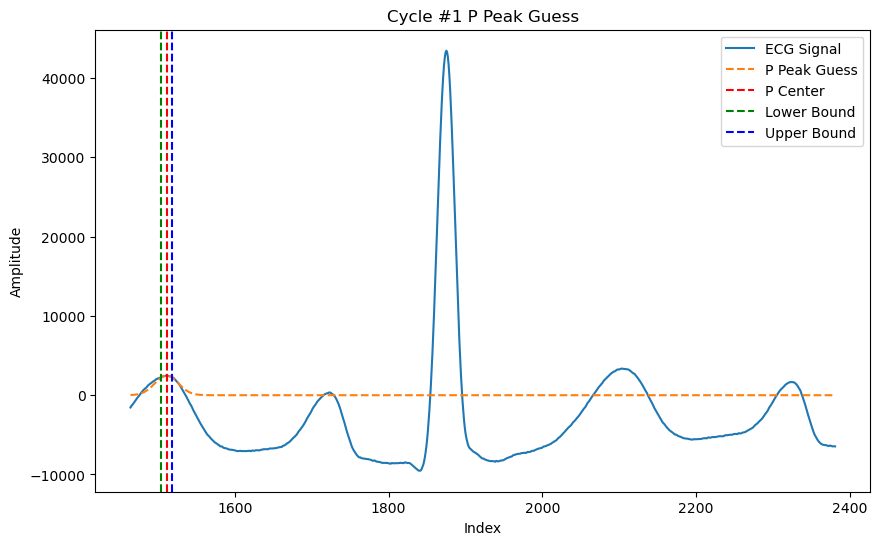

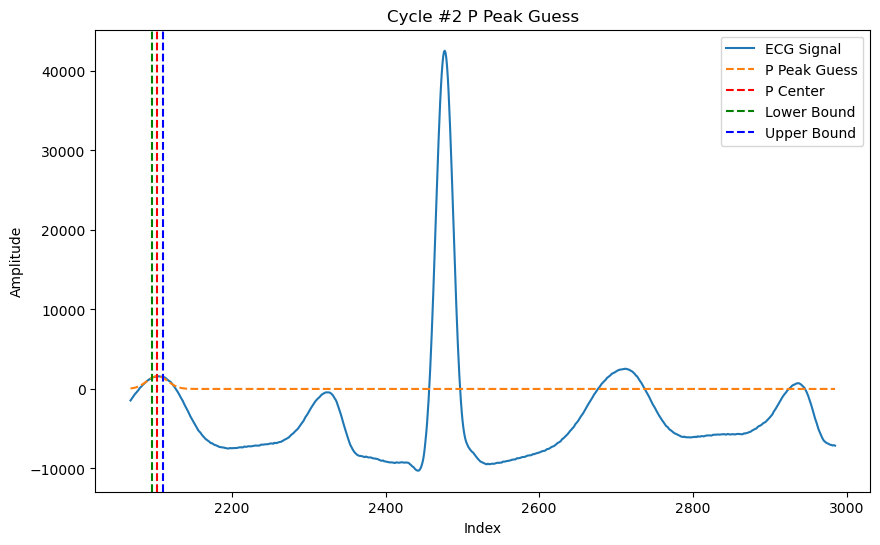

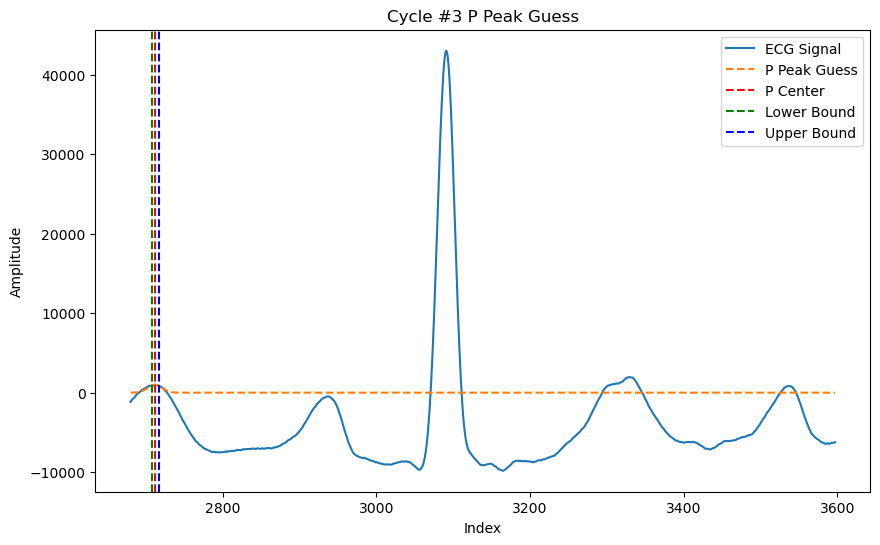

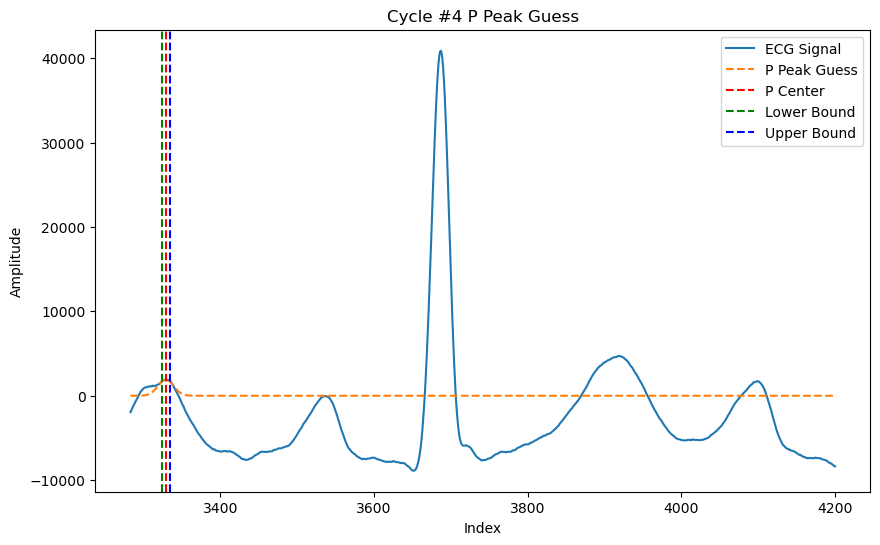

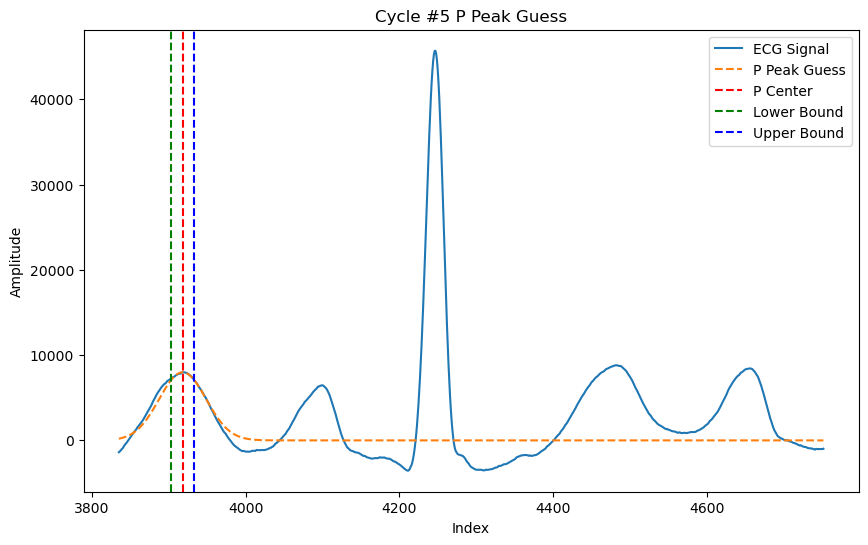

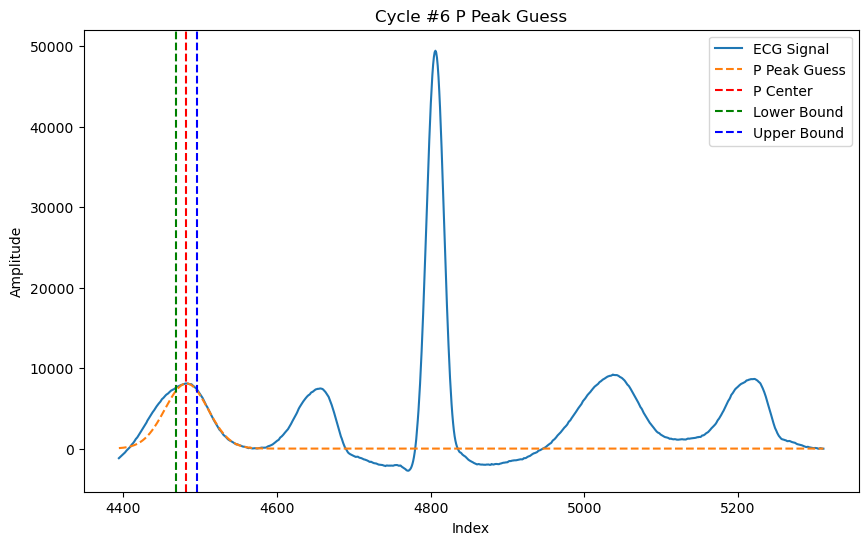

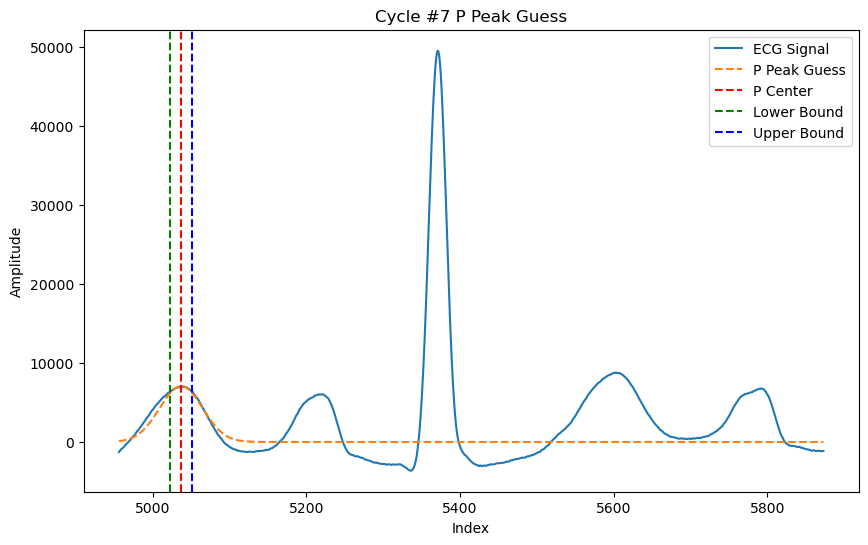

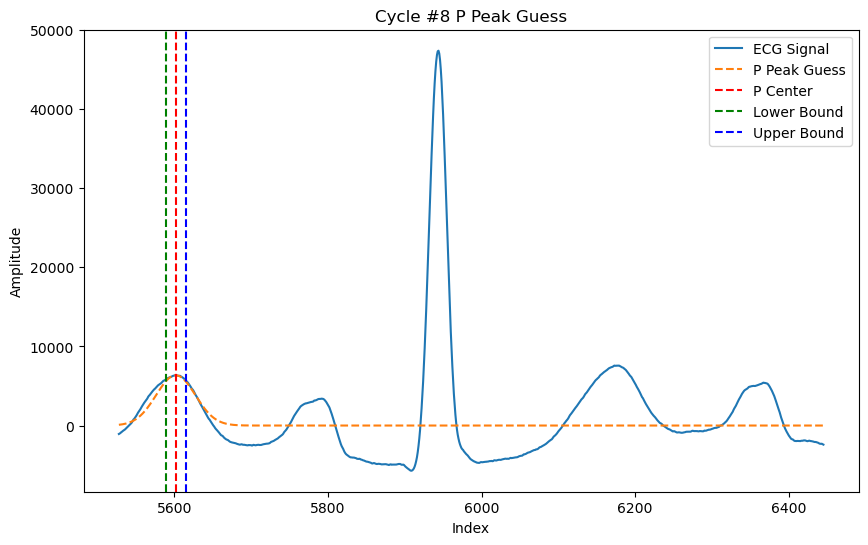

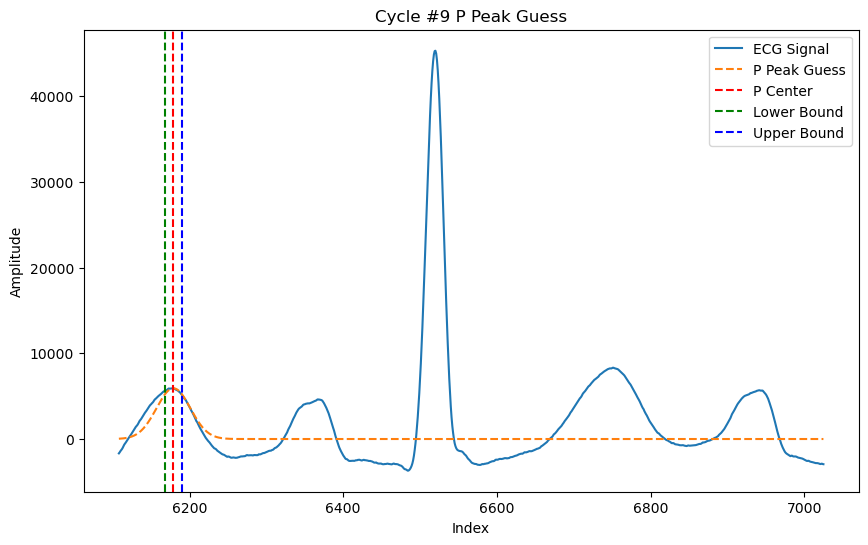

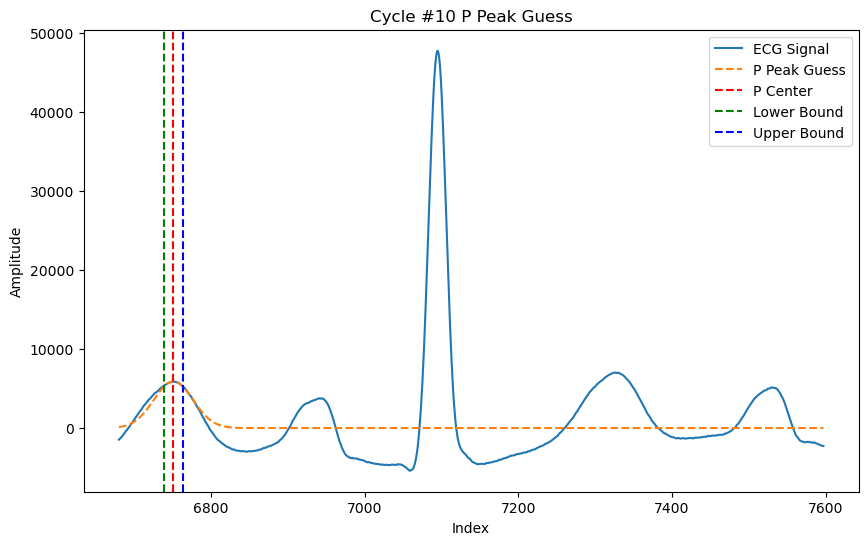

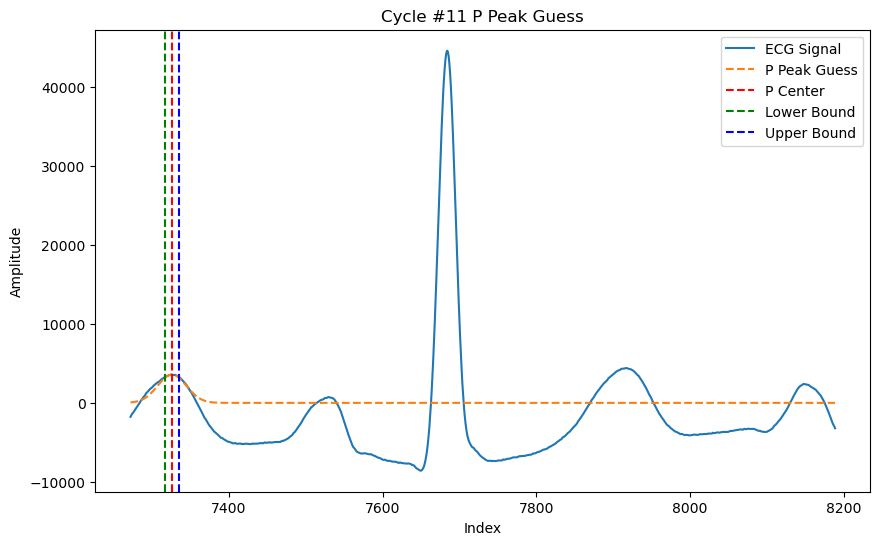

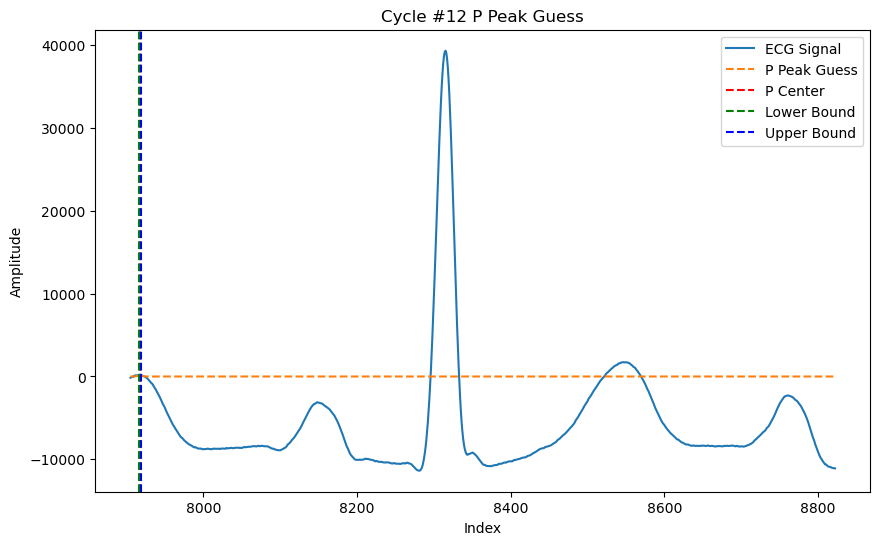

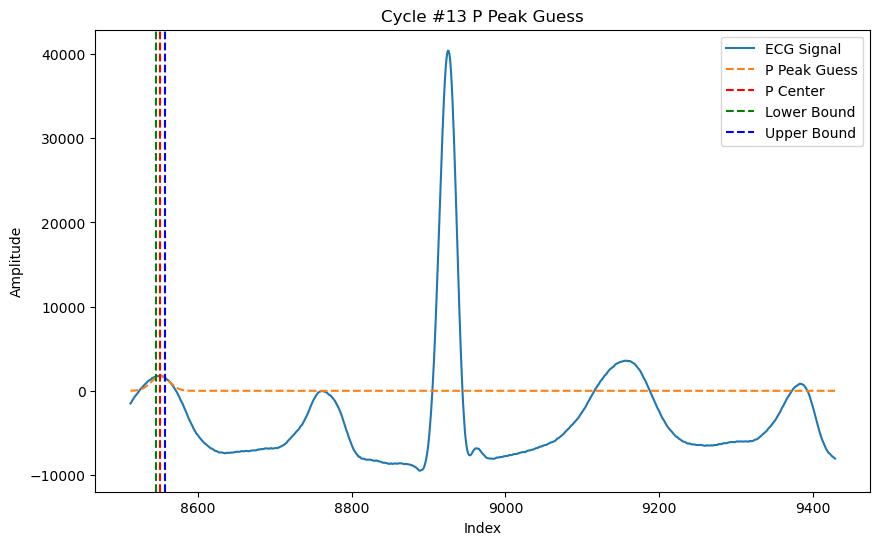

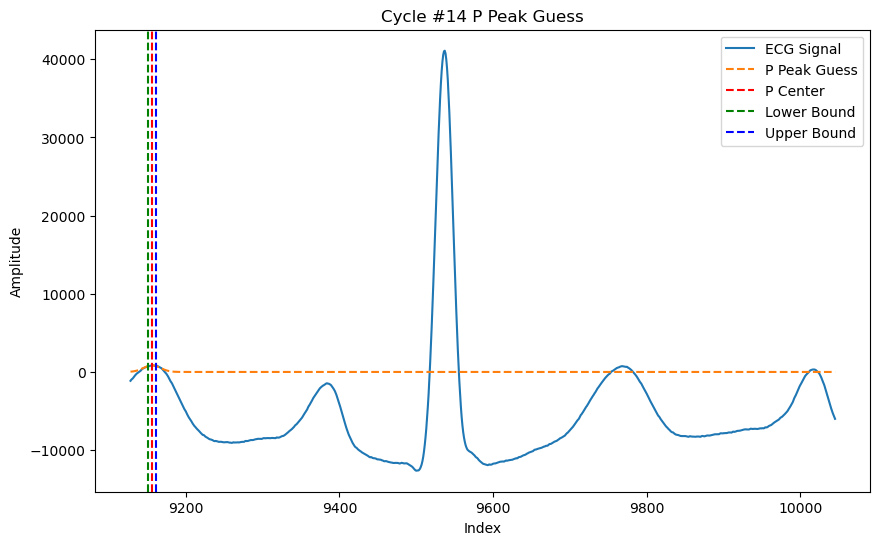

/var/folders/9k/cj6g80hn61178wfcf5w9fdjm0000gn/T/ipykernel_50115/1063099298.py:5: RuntimeWarning: divide by zero encountered in divide
  return height * np.exp(-((x - mean) ** 2) / (2 * std ** 2))
/var/folders/9k/cj6g80hn61178wfcf5w9fdjm0000gn/T/ipykernel_50115/1063099298.py:5: RuntimeWarning: invalid value encountered in divide
  return height * np.exp(-((x - mean) ** 2) / (2 * std ** 2))


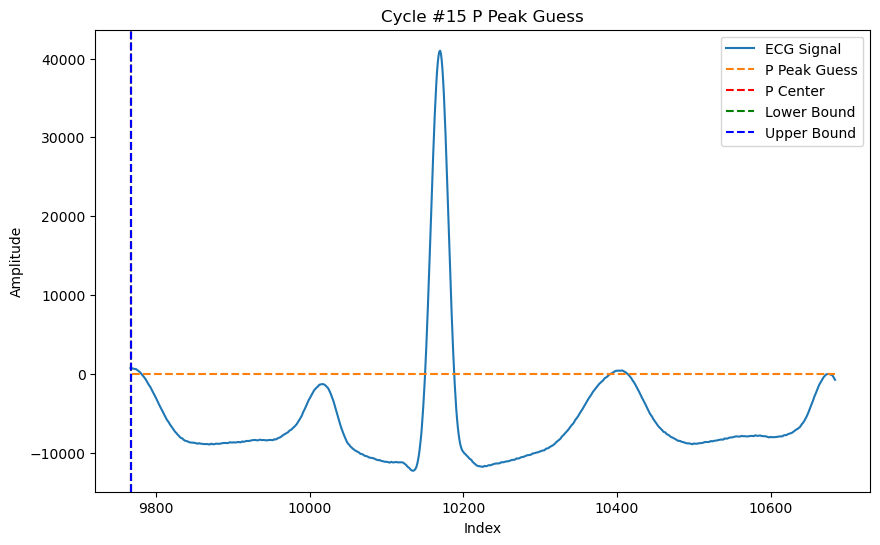

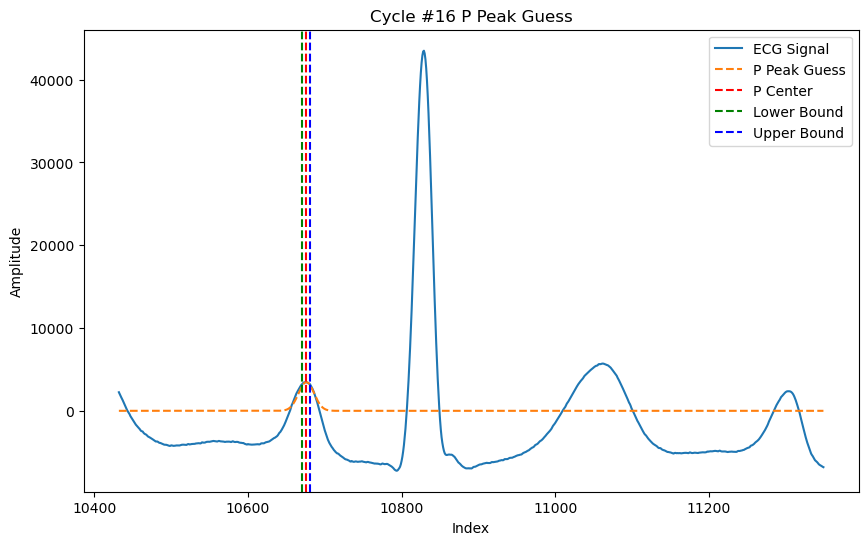

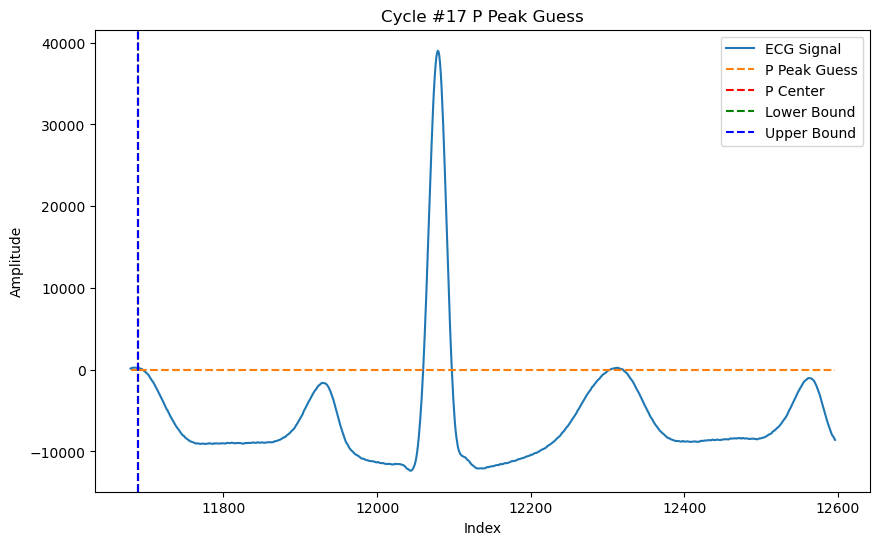

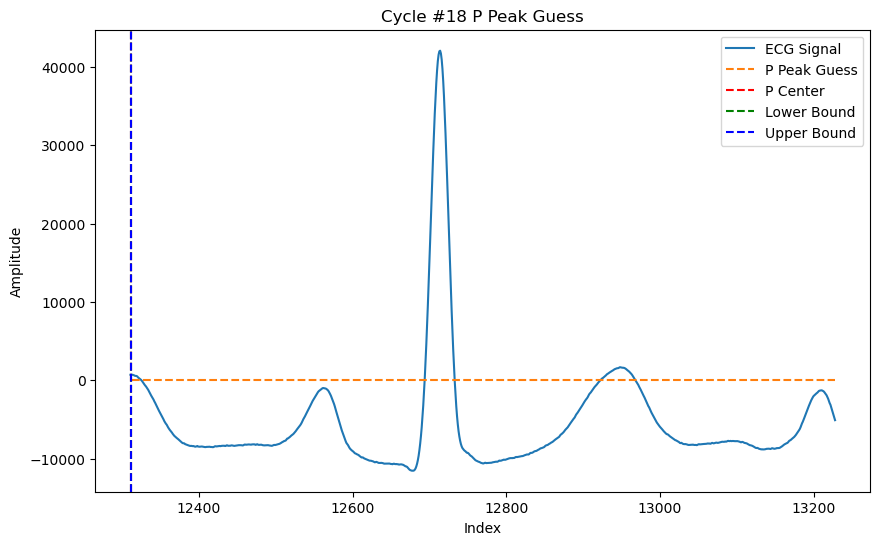

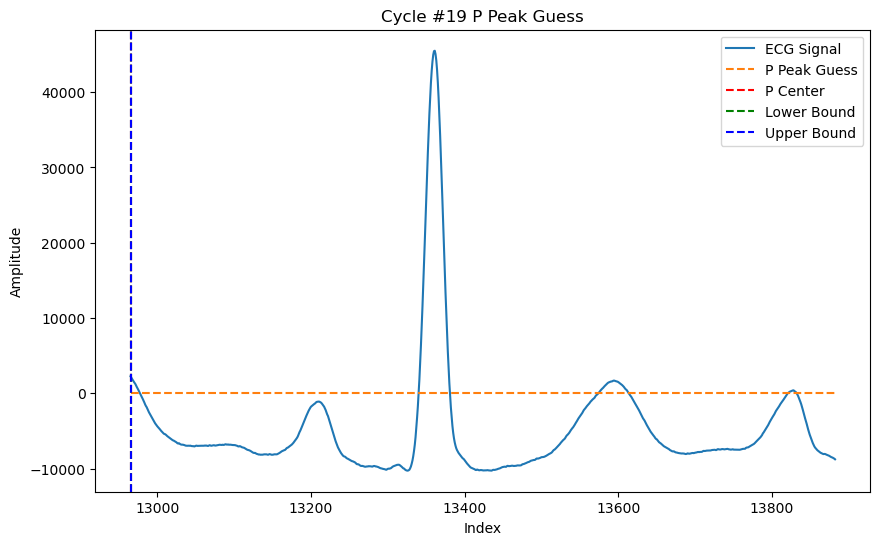

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def gaussian_function(x, mean, height, std):
    return height * np.exp(-((x - mean) ** 2) / (2 * std ** 2))

def plot_p_peak_guess(xs, sig, p_center, p_height, p_width, cycle):
    plt.figure(figsize=(10, 6))
    plt.plot(xs, sig, label='ECG Signal')
    
    # Plot P peak guess
    p_peak = gaussian_function(xs, p_center, p_height, p_width)
    plt.plot(xs, p_peak, label='P Peak Guess', linestyle='--')
    
    # Plot center and bounds
    plt.axvline(x=p_center, color='r', linestyle='--', label='P Center')
    plt.axvline(x=p_center - 0.5 * p_width, color='g', linestyle='--', label='Lower Bound')
    plt.axvline(x=p_center + 0.5 * p_width, color='b', linestyle='--', label='Upper Bound')
    
    plt.title(f'Cycle #{cycle} P Peak Guess')
    plt.xlabel('Index')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

# Plotting for each cycle
    #len(epochs_df['cycle'].unique())
    
for cycle in np.arange(0,20):
    one_cycle = epochs_df.loc[epochs_df['cycle'] == cycle]

    if one_cycle.empty or one_cycle['signal_y'].isnull().values.any():
        continue

    # X values and Y values with offset correction
    xs = np.arange(one_cycle['index'].iloc[0], one_cycle['index'].iloc[-1] + 1)
    sig = np.asarray(one_cycle['signal_y'])
    sig_flat = detrend(sig)
    sig = sig_flat - np.mean(sig_flat[0:25])
    
    r_ind = np.argmax(sig)
    r_height = sig[r_ind]
    r_center = xs[r_ind]

    half_r_height = 0.5 * r_height
    le_ind_r, ri_ind_r = find_peak_boundaries(sig, r_ind, peak_height=r_height)

    fwhm_r = estimate_fwhm(le_ind_r, ri_ind_r, r_ind)
    if fwhm_r is None:
        continue

    # Finding P, Q, S, T components
    q_min_ind = int(r_ind - (FWHM_Q_IND * fwhm_r))
    q_ind, q_height, q_center = find_extremum(sig, xs, q_min_ind, r_ind, mode='min')
    p_ind, p_height, p_center = find_extremum(sig, xs, 0, q_ind, mode='max')
    s_max_ind = int(r_ind + (FWHM_S_IND * fwhm_r))
    s_ind, s_height, s_center = find_extremum(sig, xs, r_ind, s_max_ind, mode='min')
    t_ind, t_height, t_center = find_extremum(sig, xs, s_ind, len(sig), mode='max')

    component_inds = {
        'p': [p_ind, p_height, p_center],
        'q': [q_ind, q_height, q_center],
        'r': [r_ind, r_height, r_center],  
        's': [s_ind, s_height, s_center],
        't': [t_ind, t_height, t_center]
    }

    guess = np.empty([0, 3])
    if component_inds['p'][1] < 0 or component_inds['r'][1] < 0 or component_inds['t'][1] < 0:
        continue

    # Initialize an empty list for storing guess parameters
    guess_params = []
    
    for comp, params in component_inds.items():
        onset, offset = find_peak_boundaries(sig, peak_index=params[0], peak_height=params[1])
        
        ecg_output_dict[f'{comp}_on'][cycle] = xs[onset] if onset is not None else np.nan
        ecg_output_dict[f'{comp}_off'][cycle] = xs[offset] if offset is not None else np.nan

        if onset is not None and offset is not None:
            short_side = min(abs(params[0] - onset), abs(offset - params[0]))
        else:
            short_side = 0

        fwhm = short_side * 2
        guess_std = compute_gauss_std(fwhm)

        guess = np.vstack((guess, (params[2], params[1], guess_std)))
        peak_gauss = gaussian_function(xs, params[2], params[1], guess_std)

    # Plot the P peak guess for the current cycle
    plot_p_peak_guess(xs, sig, component_inds['p'][2], component_inds['p'][1], guess[0][2], cycle)


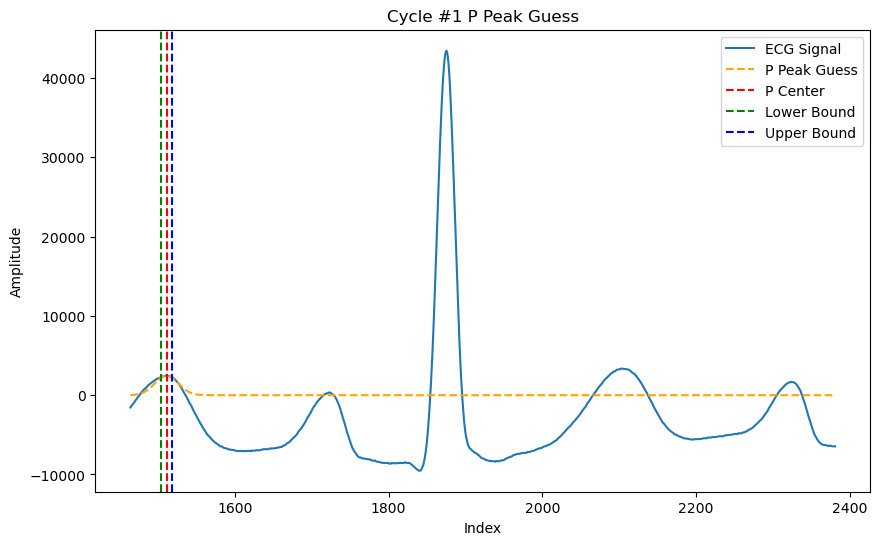

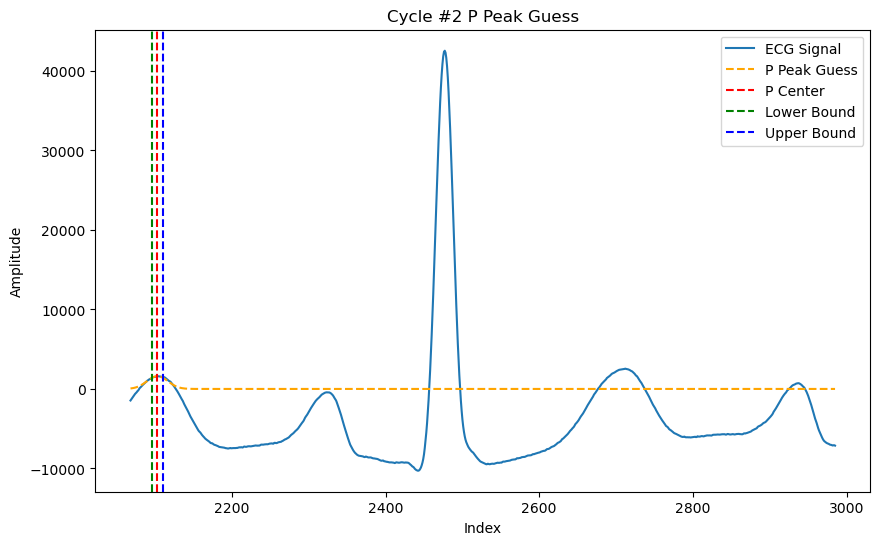

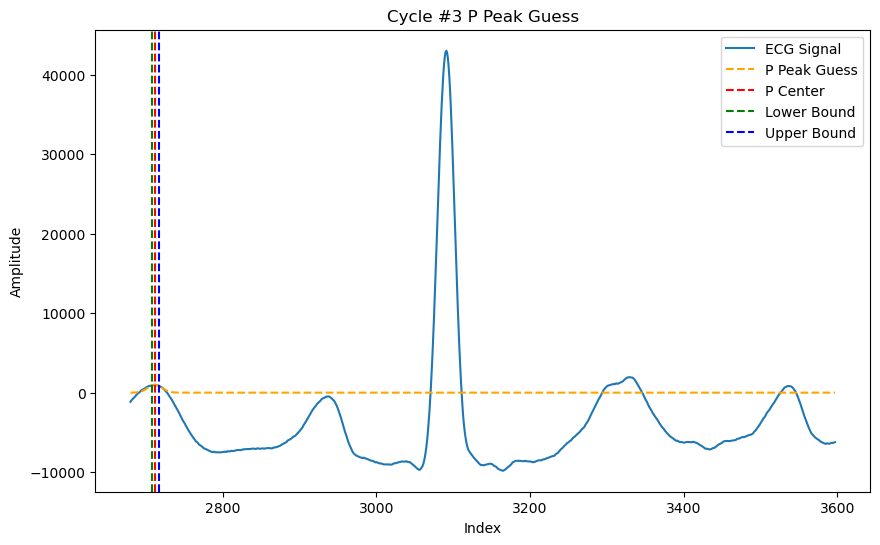

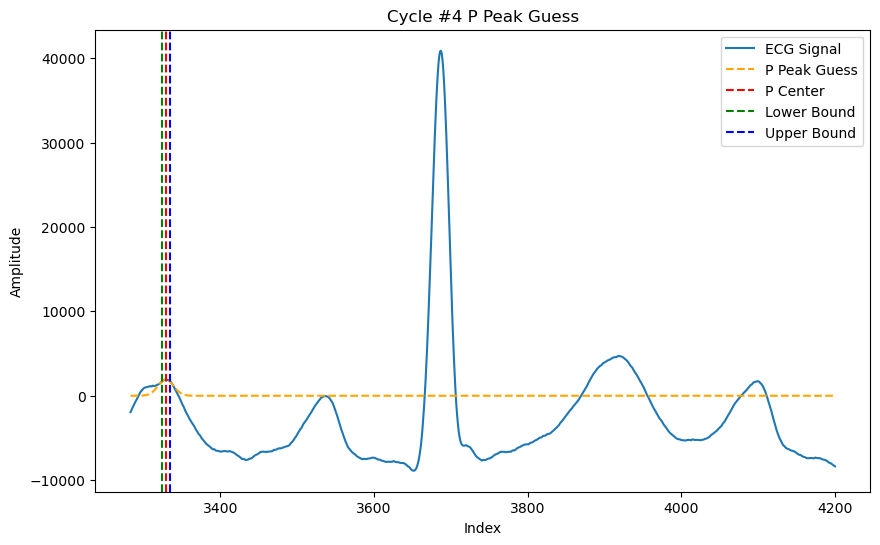

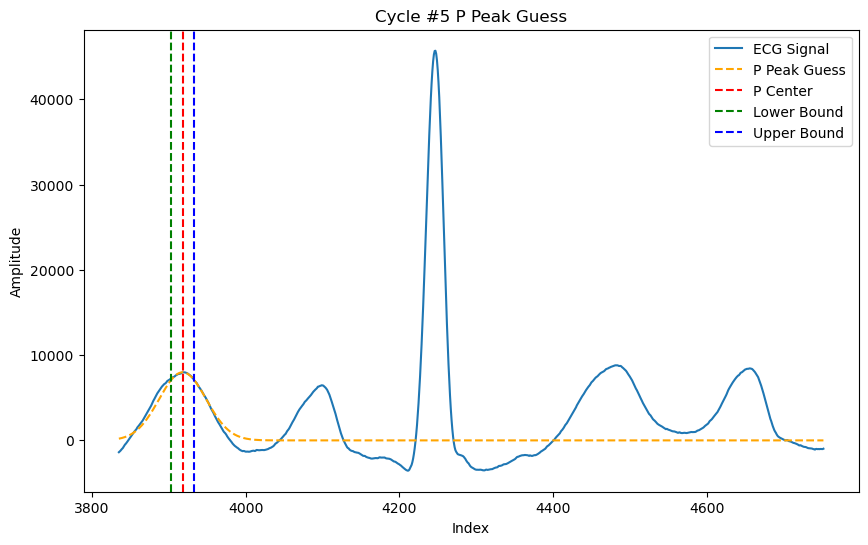

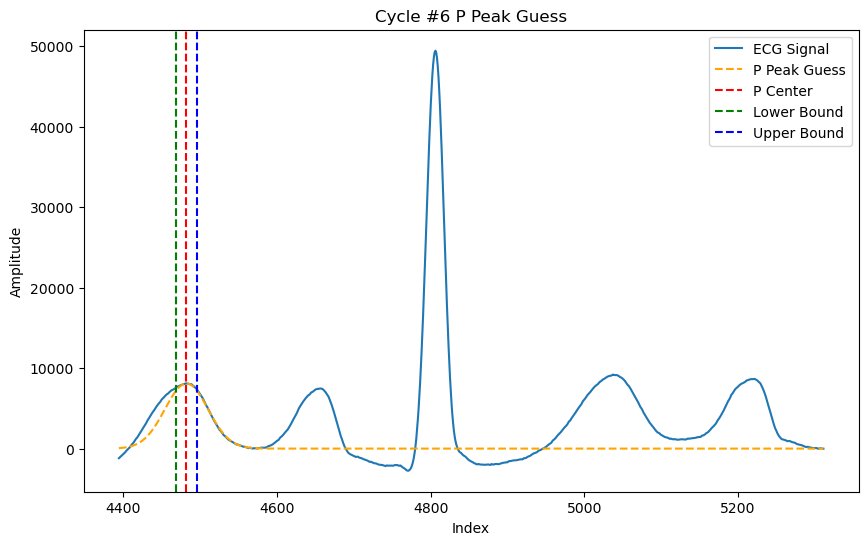

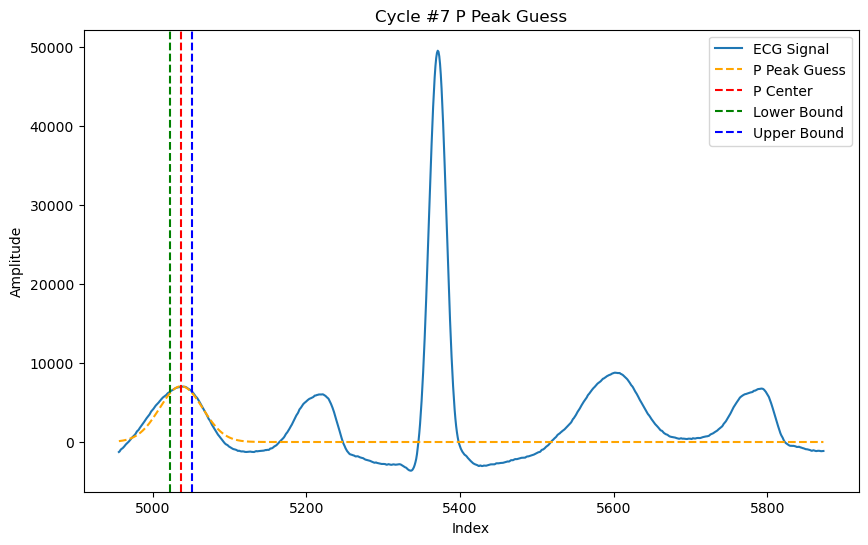

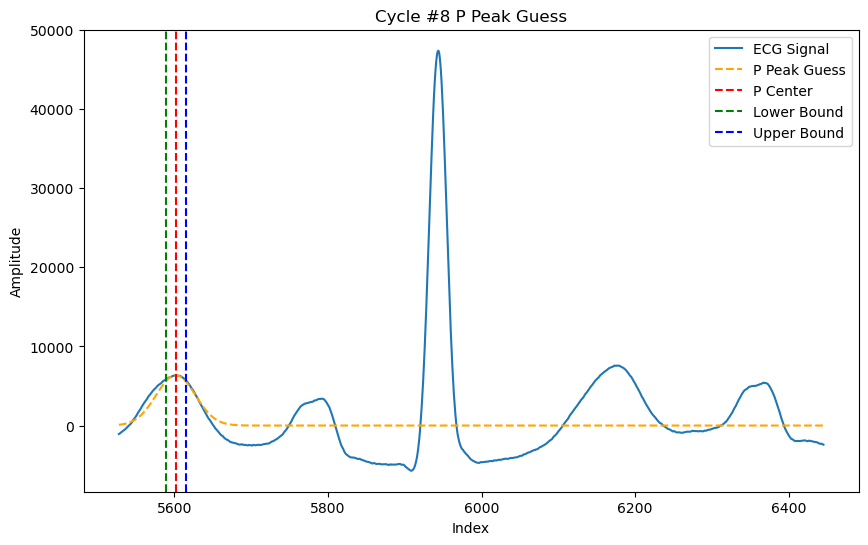

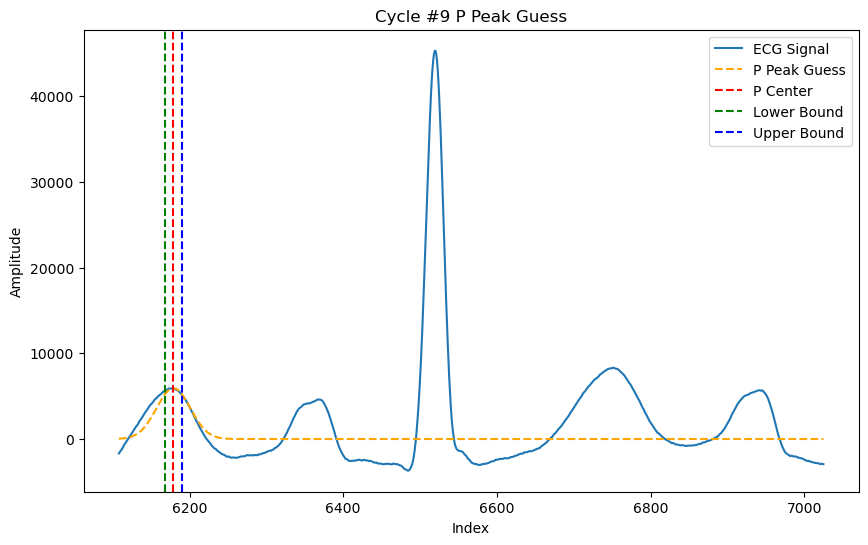

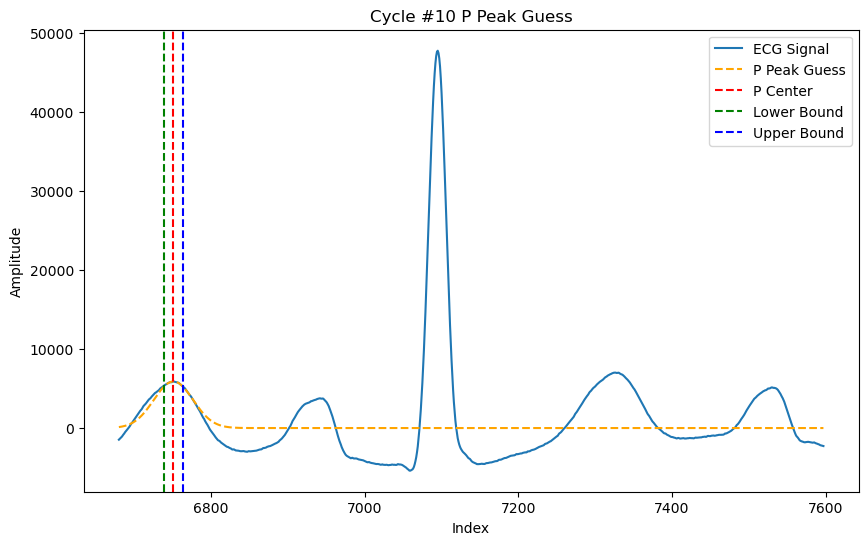

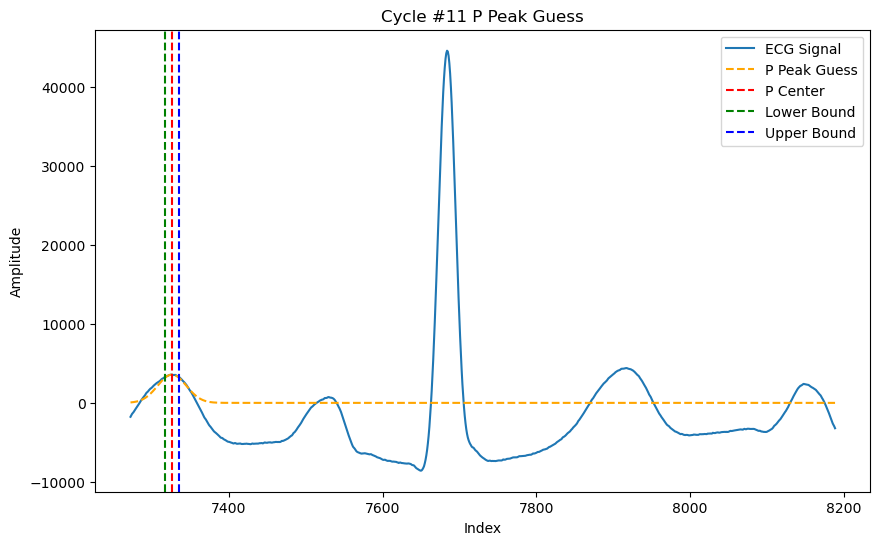

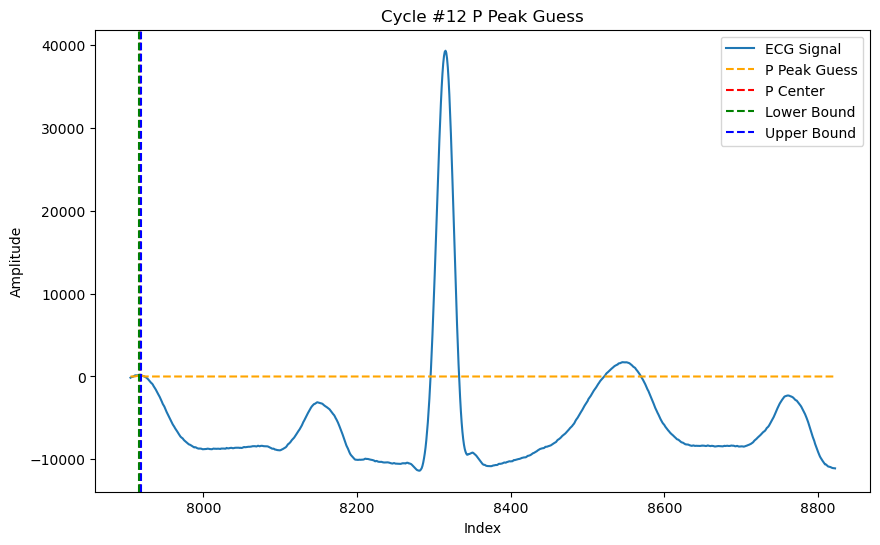

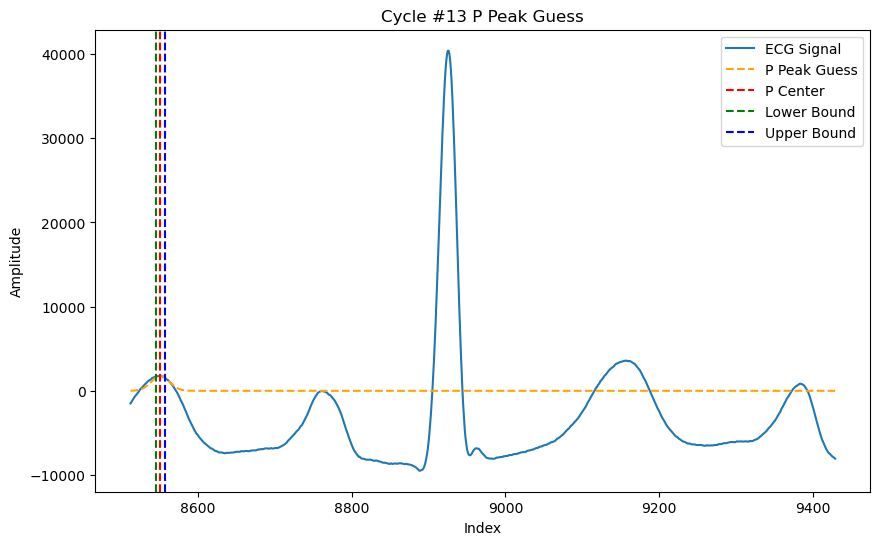

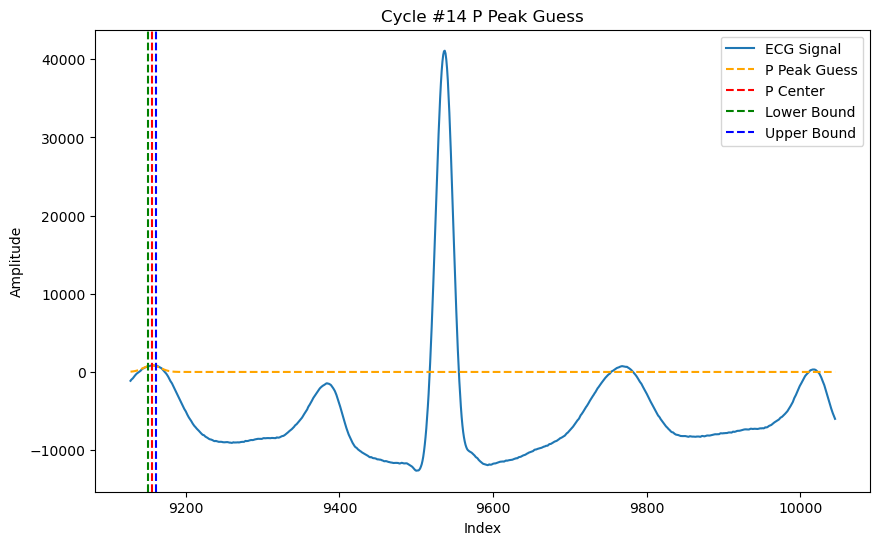

/var/folders/9k/cj6g80hn61178wfcf5w9fdjm0000gn/T/ipykernel_50115/1724378647.py:6: RuntimeWarning: divide by zero encountered in divide
  return height * np.exp(-((x - mean) ** 2) / (2 * std ** 2))
/var/folders/9k/cj6g80hn61178wfcf5w9fdjm0000gn/T/ipykernel_50115/1724378647.py:6: RuntimeWarning: invalid value encountered in divide
  return height * np.exp(-((x - mean) ** 2) / (2 * std ** 2))


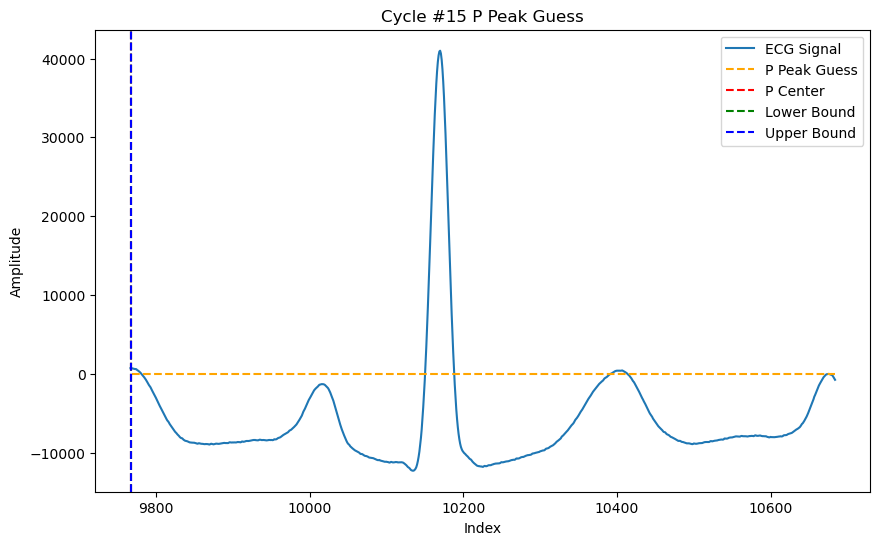

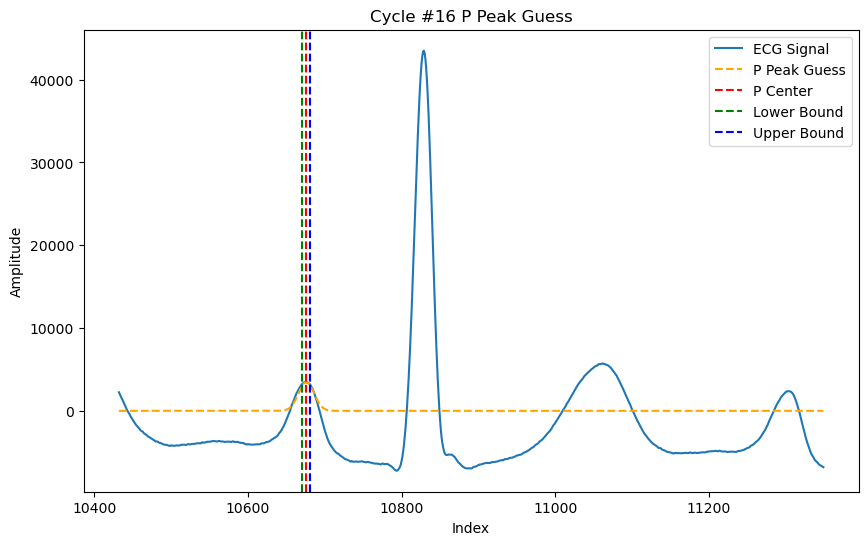

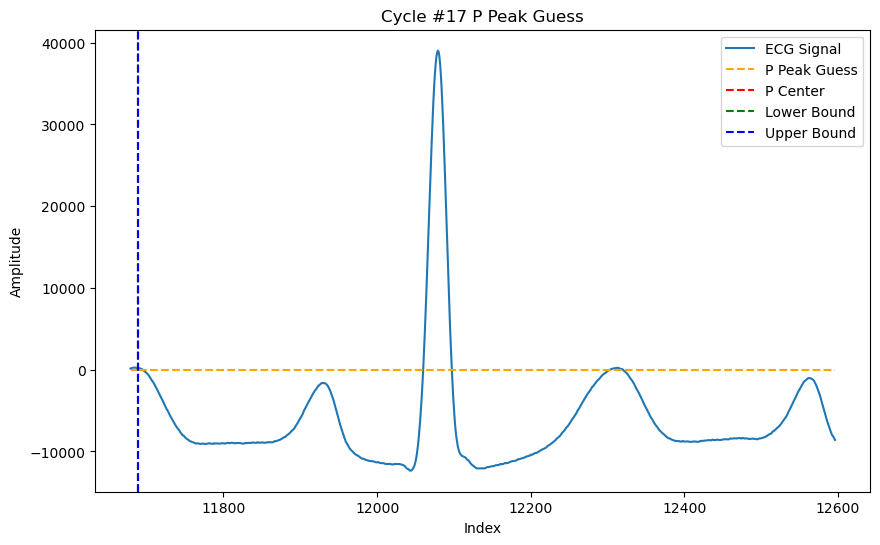

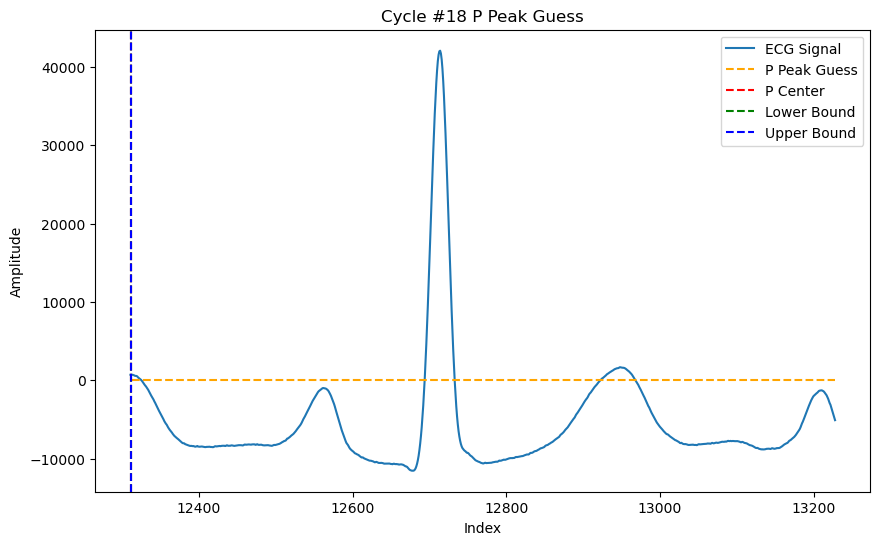

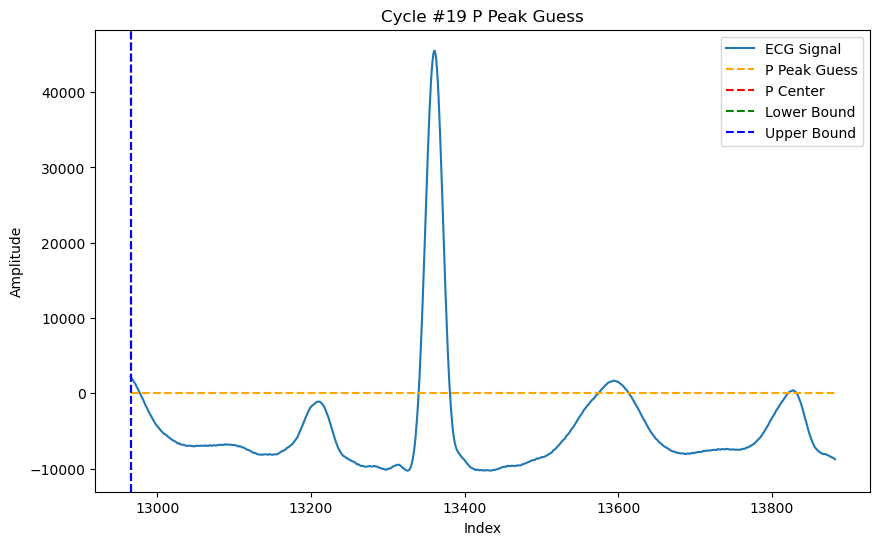

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import detrend

def gaussian_function(x, mean, height, std):
    return height * np.exp(-((x - mean) ** 2) / (2 * std ** 2))

def plot_p_peak_guess(xs, sig, p_center, p_height, p_width, cycle):
    plt.figure(figsize=(10, 6))
    plt.plot(xs, sig, label='ECG Signal')
    
    # Plot P peak guess
    p_peak = gaussian_function(xs, p_center, p_height, p_width)
    plt.plot(xs, p_peak, label='P Peak Guess', linestyle='--', color='orange')
    
    # Plot center and bounds
    plt.axvline(x=p_center, color='r', linestyle='--', label='P Center')
    plt.axvline(x=p_center - 0.5 * p_width, color='g', linestyle='--', label='Lower Bound')
    plt.axvline(x=p_center + 0.5 * p_width, color='b', linestyle='--', label='Upper Bound')
    
    plt.title(f'Cycle #{cycle} P Peak Guess')
    plt.xlabel('Index')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

# Plotting for each cycle
for cycle in np.arange(0, 20):  # Adjust the range as needed
    one_cycle = epochs_df.loc[epochs_df['cycle'] == cycle]

    if one_cycle.empty or one_cycle['signal_y'].isnull().values.any():
        continue

    # X values and Y values with offset correction
    xs = np.arange(one_cycle['index'].iloc[0], one_cycle['index'].iloc[-1] + 1)
    sig = np.asarray(one_cycle['signal_y'])
    sig_flat = detrend(sig)
    sig = sig_flat - np.mean(sig_flat[0:25])
    
    r_ind = np.argmax(sig)
    r_height = sig[r_ind]
    r_center = xs[r_ind]

    half_r_height = 0.5 * r_height
    le_ind_r, ri_ind_r = find_peak_boundaries(sig, r_ind, peak_height=r_height)

    fwhm_r = estimate_fwhm(le_ind_r, ri_ind_r, r_ind)
    if fwhm_r is None:
        continue

    # Finding P, Q, S, T components
    q_min_ind = int(r_ind - (FWHM_Q_IND * fwhm_r))
    q_ind, q_height, q_center = find_extremum(sig, xs, q_min_ind, r_ind, mode='min')
    p_ind, p_height, p_center = find_extremum(sig, xs, 0, q_ind, mode='max')
    s_max_ind = int(r_ind + (FWHM_S_IND * fwhm_r))
    s_ind, s_height, s_center = find_extremum(sig, xs, r_ind, s_max_ind, mode='min')
    t_ind, t_height, t_center = find_extremum(sig, xs, s_ind, len(sig), mode='max')

    component_inds = {
        'p': [p_ind, p_height, p_center],
        'q': [q_ind, q_height, q_center],
        'r': [r_ind, r_height, r_center],  
        's': [s_ind, s_height, s_center],
        't': [t_ind, t_height, t_center]
    }

    guess = np.empty([0, 3])
    if component_inds['p'][1] < 0 or component_inds['r'][1] < 0 or component_inds['t'][1] < 0:
        continue

    for comp, params in component_inds.items():
        onset, offset = find_peak_boundaries(sig, peak_index=params[0], peak_height=params[1])
        ecg_output_dict[f'{comp}_on'][cycle] = xs[onset] if onset is not None else np.nan
        ecg_output_dict[f'{comp}_off'][cycle] = xs[offset] if offset is not None else np.nan

        if onset is not None and offset is not None:
            short_side = min(abs(params[0] - onset), abs(offset - params[0]))
        else:
            short_side = 0

        fwhm = short_side * 2
        guess_std = compute_gauss_std(fwhm)

        guess = np.vstack((guess, (params[2], params[1], guess_std)))
        peak_gauss = gaussian_function(xs, params[2], params[1], guess_std)

    # Plot the P peak guess for the current cycle
    plot_p_peak_guess(xs, sig, component_inds['p'][2], component_inds['p'][1], guess[0][2], cycle)


In [251]:
# Convert dictionary to DataFrame
ecg_output = pd.DataFrame(ecg_output_dict)


22
1522


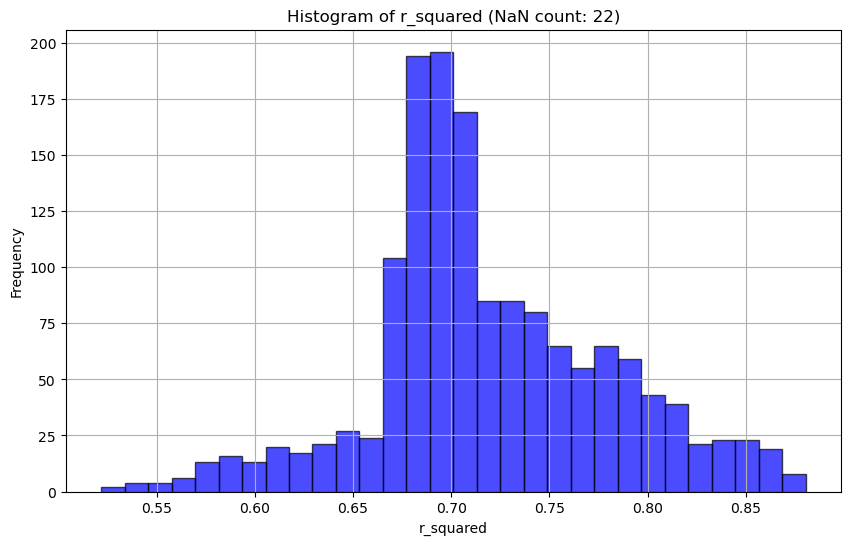

In [252]:
# Calculate the number of NaN values in r_squared
nan_count = ecg_output['r_squared'].isna().sum()
print(nan_count)

print(num_cycles)


# Plotting the histogram for r_squared
plt.figure(figsize=(10, 6))
plt.hist(ecg_output['r_squared'].dropna(), bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title(f'Histogram of r_squared (NaN count: {nan_count})')
plt.xlabel('r_squared')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


R-squared for cycle #210: 0.7975688680227654


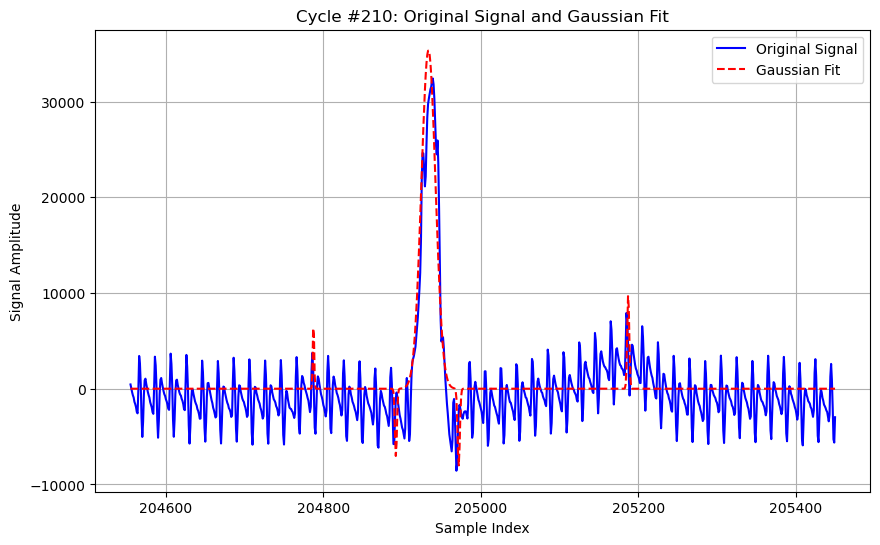

In [254]:
##Checking cycles 

cycle = 210

# If you've stored the original signal and fitting results in a DataFrame or similar structure, retrieve them
# For example, if `xs` and `sig` were stored or can be recalculated for cycle 39:
one_cycle = epochs_df.loc[epochs_df['cycle'] == cycle]
xs = np.arange(one_cycle['index'].iloc[0], one_cycle['index'].iloc[-1]+1)
sig = np.asarray(one_cycle['signal_y'])

# Assuming `fit` contains the fitted curve for cycle 39, which might have been stored or can be recalculated
# If you saved the fitting parameters per cycle, retrieve and use them to regenerate the fit curve
# Example: gaussian_params = ecg_output.loc[cycle, fitting_param_columns]
# fit = gaussian_function(xs, *gaussian_params)

# Now, plot the original signal and the fitted curve for cycle 39
plt.figure(figsize=(10, 6))
plt.plot(xs, sig, label='Original Signal', color='blue')
plt.plot(xs, fit, label='Gaussian Fit', color='red', linestyle='--')

# Assuming `ecg_output` is your DataFrame and it contains an 'r_squared' column
r_squared_value = ecg_output.loc[cycle, 'r_squared']

print(f'R-squared for cycle #{cycle}: {r_squared_value}')

# # Marking components if needed; assuming you have markers for components (like R peaks, etc.)
# # If you've extracted specific points (e.g., R peaks) and want to mark them:
# for comp in ['p', 'q', 'r', 's', 't']:
#     if comp+'_on' in ecg_output.columns and comp+'_off' in ecg_output.columns:
#         on_point = ecg_output.loc[cycle, comp+'_on']
#         off_point = ecg_output.loc[cycle, comp+'_off']
#         plt.scatter([on_point, off_point], [sig[xs==on_point], sig[xs==off_point]], marker='o', label=f'{comp} points')

plt.title(f'Cycle #{cycle}: Original Signal and Gaussian Fit')
plt.xlabel('Sample Index')
plt.ylabel('Signal Amplitude')
plt.legend()
plt.grid(True)
plt.show()
